In [53]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Masking
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [54]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [55]:
tf.keras.backend.clear_session()

In [56]:
data_dir = './data/'

In [57]:
#
# Global warming: monthly temperature anomaly
# The combined land-surface air and sea-surface water temperature anomaly is given as the deviation from the 1951 - 1980 mean.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Temperature+anomaly&Long-run+series%3F=false
#

#
# Global warming: monthly sea surface temperature anomaly
# This is measured at a nominal depth of 20cm, and given relative to the average temperature from the period of 1961 - 1990.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Sea+surface+temperature+anomaly&Long-run+series%3F=false
#

df1 = pd.read_csv(data_dir + 'climate-change-air-world.csv', low_memory=False)
df1.drop(df1[df1.Entity != 'World'].index, inplace=True)
df1.drop(columns=['Code', 'Entity'], inplace=True)
df1.rename(columns={'temperature_anomaly': 'world_air_temperature_anomaly'}, inplace=True)

df2 = pd.read_csv(data_dir + 'climate-change-water-world.csv', low_memory=False)
df2.drop(df2[df2.Entity != 'World'].index, inplace=True)
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'monthly_sea_surface_temperature_anomaly': 'world_sea_temperature_anomaly'}, inplace=True)

df = df1.merge(df2, on="Day", how = 'inner')
print("df.shape:")
print(df.shape)
df.head()

df.shape:
(1703, 3)


,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
0,1880-01-15,-0.17,-0.2283
1,1880-02-15,-0.22,-0.1353
2,1880-03-15,-0.08,-0.0102
3,1880-04-15,-0.15,-0.1158
4,1880-05-15,-0.08,-0.3387


In [58]:
df.tail()

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
1698,2021-07-15,0.92,0.7308
1699,2021-08-15,0.82,0.7242
1700,2021-09-15,0.92,0.7127
1701,2021-10-15,0.98,0.6909
1702,2021-11-15,0.94,0.6813


In [59]:
orig_x_axis = df['Day']

# The label for the predicted value - needs to be one unit bigger than what is shown in previous cell
future_x_axis = orig_x_axis.append(pd.Series(['2021-12-15']))

In [60]:
# Save main dataframe for use at the end of notebook - do a deep copy here
master_df = pd.DataFrame(df).copy()

#
# Drop what's needed for the initial models which only uses one data column
# It is safe to drop dates (Day column) since they are all evenly spaced
#
df.drop(columns=['Day', 'world_sea_temperature_anomaly'], inplace=True)

# To keep dates must use the following (and adjust rest of code)
#df['Day'] =  pd.to_numeric(pd.to_datetime(df['Day'], format='%Y-%m-%d'))

df.head()

,world_air_temperature_anomaly
0,-0.17
1,-0.22
2,-0.08
3,-0.15
4,-0.08


In [61]:
df.tail()

,world_air_temperature_anomaly
1698,0.92
1699,0.82
1700,0.92
1701,0.98
1702,0.94


# _**Climate Change Time-Series Forecast Models**_
### Prepare the data

In [10]:
#
# Set parameter on how much to print for numpy arrays
#

#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=False)

In [11]:
#
# Create the dataset
#
dataset = df.values
dataset = dataset.astype('float32')


#
# Create numpy dataset
# reshape into X=t and Y=t+1
#
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
     
    for i in range(len(dataset) - look_back):  # -1
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


#
# Normalize the dataset with scikit-learn MinMaxScaler
#
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
#
# Split into train and test sets: 70%, 30%
#
print("Dataset length:")
print(len(dataset))
print()

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("Training size:")
print(train_size)
print()
print("Test size:")
print(test_size)
print()

#
# Reshape into X=t and Y=t+lookback
#
look_back = 1
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

Dataset length:
1703

Training size:
1277

Test size:
426

trainX.shape:
(1276, 1)

trainY.shape:
(1276,)

testX.shape:
(425, 1)

testY.shape:
(425,)



In [13]:
# Currently the data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using np.reshape() as follows:
#
#
#
# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# ONLY THE INPUT X - NOT THE Y VALUES
#
# trainX shape: (1276, 1)
# trainY shape: (1276,)
# testX shape: (425, 1)
# testY shape: (425,)
#
#
# Reshape input to be [samples, time steps, features]
#

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX.shape:")
print(trainX.shape)
print()

print("trainY.shape:")
print(trainY.shape)
print()

print("testX.shape:")
print(testX.shape)
print()

print("testY.shape:")
print(testY.shape)
print()

trainX.shape:
(1276, 1, 1)

trainY.shape:
(1276,)

testX.shape:
(425, 1, 1)

testY.shape:
(425,)



In [14]:
#
# Get last dataset entry to make one future prediction
#

def get_last_dataset_entry():
    last_entry = df.values[len(df.values)-1]
    last_entry = last_entry.astype('float32')
    
    print("Last data point:")
    print(last_entry)
    print()
    
    last_entry = last_entry.reshape(1, -1)

    last_entry = scaler.transform(last_entry)
    last_entry = np.reshape(last_entry, (1,1,1))
    
    return last_entry

last_entry = get_last_dataset_entry()
print("Scaled last entry:")
print(last_entry)

Last data point:
[0.94]

Scaled last entry:
[[[0.8036529]]]


## **Create the Non-Stacked LSTM model**

In [15]:
#
# Create LSTM model #1 (unstacked)
#


# TODO: Fix this so there is not a gap between train and test - let train data look in one element into test
def create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):

    model_unstacked = Sequential([
        LSTM(20, stateful=False, input_shape=(trainX.shape[1],1), name='layer1'),         # , batch_input_shape(64,10,1)  batch_input_shape=(1, look_back)
        Dense(1, name='Output')
    ])
    
    opt = Adam(learning_rate=lrate)
    
    model_unstacked.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    
    model_unstacked.summary()
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard/nonstacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )

    history_unstacked = model_unstacked.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(testX, testY),
        callbacks = [tensorboard]
    )
    
    print("Running Unstacked Model's Evaluate")
    loss, accuracy = model_unstacked.evaluate(testX, testY)
    print("loss:")
    print(loss)
    print("accuracy:")
    print(accuracy)
    
    return history_unstacked, model_unstacked

## **Create the Stacked LSTM model**

In [16]:
#
# Create LSTM model #2 - stacked
#

def create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    model_stacked = Sequential([
        LSTM(20, return_sequences=True, input_shape=(trainX.shape[1],1), name='layer1'),
        # Dropout(0.2),
        LSTM(20, return_sequences=False, name='layer2'),
        # Dropout(0.2),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    model_stacked.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    
    model_stacked.summary()
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard/stacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    history_stacked = model_stacked.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(testX, testY),
        callbacks = [tensorboard]
    )
    
    print("Running Stacked Model's Evaluate")
    loss, accuracy = model_stacked.evaluate(testX, testY)
    print("loss:")
    print(loss)
    print("accuracy:")
    print(accuracy)

    return history_stacked, model_stacked

## **Create the Bidirectional LSTM model**

In [17]:
#
# Create LSTM model #3 - Bidirectional
#


def create_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    bidirectional_model = Sequential([
        Bidirectional(LSTM(20, activation='relu'), input_shape=(trainX.shape[1],1), name='layer1'),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    bidirectional_model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    
    bidirectional_model.summary()
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./tensorboard/bidirectional_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    bidirectional_history = bidirectional_model.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_data=(testX, testY),
        callbacks = [tensorboard]
    )
    
    print("Running Evaluate")
    loss, accuracy = bidirectional_model.evaluate(testX, testY)
    print("loss:")
    print(loss)
    print("accuracy:")
    print(accuracy)

    return bidirectional_history, bidirectional_model

## **Run the non-stacked model**

In [18]:
#
# Run non-stacked model version
#

lrate = 0.00001
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 500

history_nonstacked_lstm, lstm_nonstacked_model = create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, batch_size)

lstm_nonstacked_model.save('./models/lstm_nonstacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_nonstacked_model.predict(trainX)
testPredict = lstm_nonstacked_model.predict(testX)
    
#
# Make next time period prediction
#
future_prediction = lstm_nonstacked_model.predict(last_entry, batch_size=30)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_nonstacked_lstm = lstm_nonstacked_model.evaluate(testX, testY, verbose=1)
print("Model Score:")
print(score_nonstacked_lstm)

2021-12-25 17:58:13.267935: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 20)                1760      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1276/1276 [==============================] - 3s 1ms/step - loss: 0.1095 - accuracy: 7.8370e-04 - val_loss: 0.4015 - val_accuracy: 0.0000e+00
Epoch 2/500
1276/1276 [==============================] - 1s 1ms/step - loss: 0.0845 - accuracy: 7.8370e-04 - val_loss: 0.3433 - val_accuracy: 0.0000e+00
Epoch 3/500
1276/1276 [==============================] - 1s 1ms/step - loss: 0.0645 - accuracy: 7.8370e-04 - val_loss: 0.2915 - val_accuracy: 0.

2021-12-25 18:10:23.959419: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


Future Prediction scaled: [[0.7641908]]
Future Prediction unscaled: [[0.8535779]]

Train Score: 0.11 RMSE
Test Score: 0.14 RMSE
14/14 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.0024
Model Score:
[0.0040330770425498486, 0.002352941082790494]


## **Plot the non-stacked model**

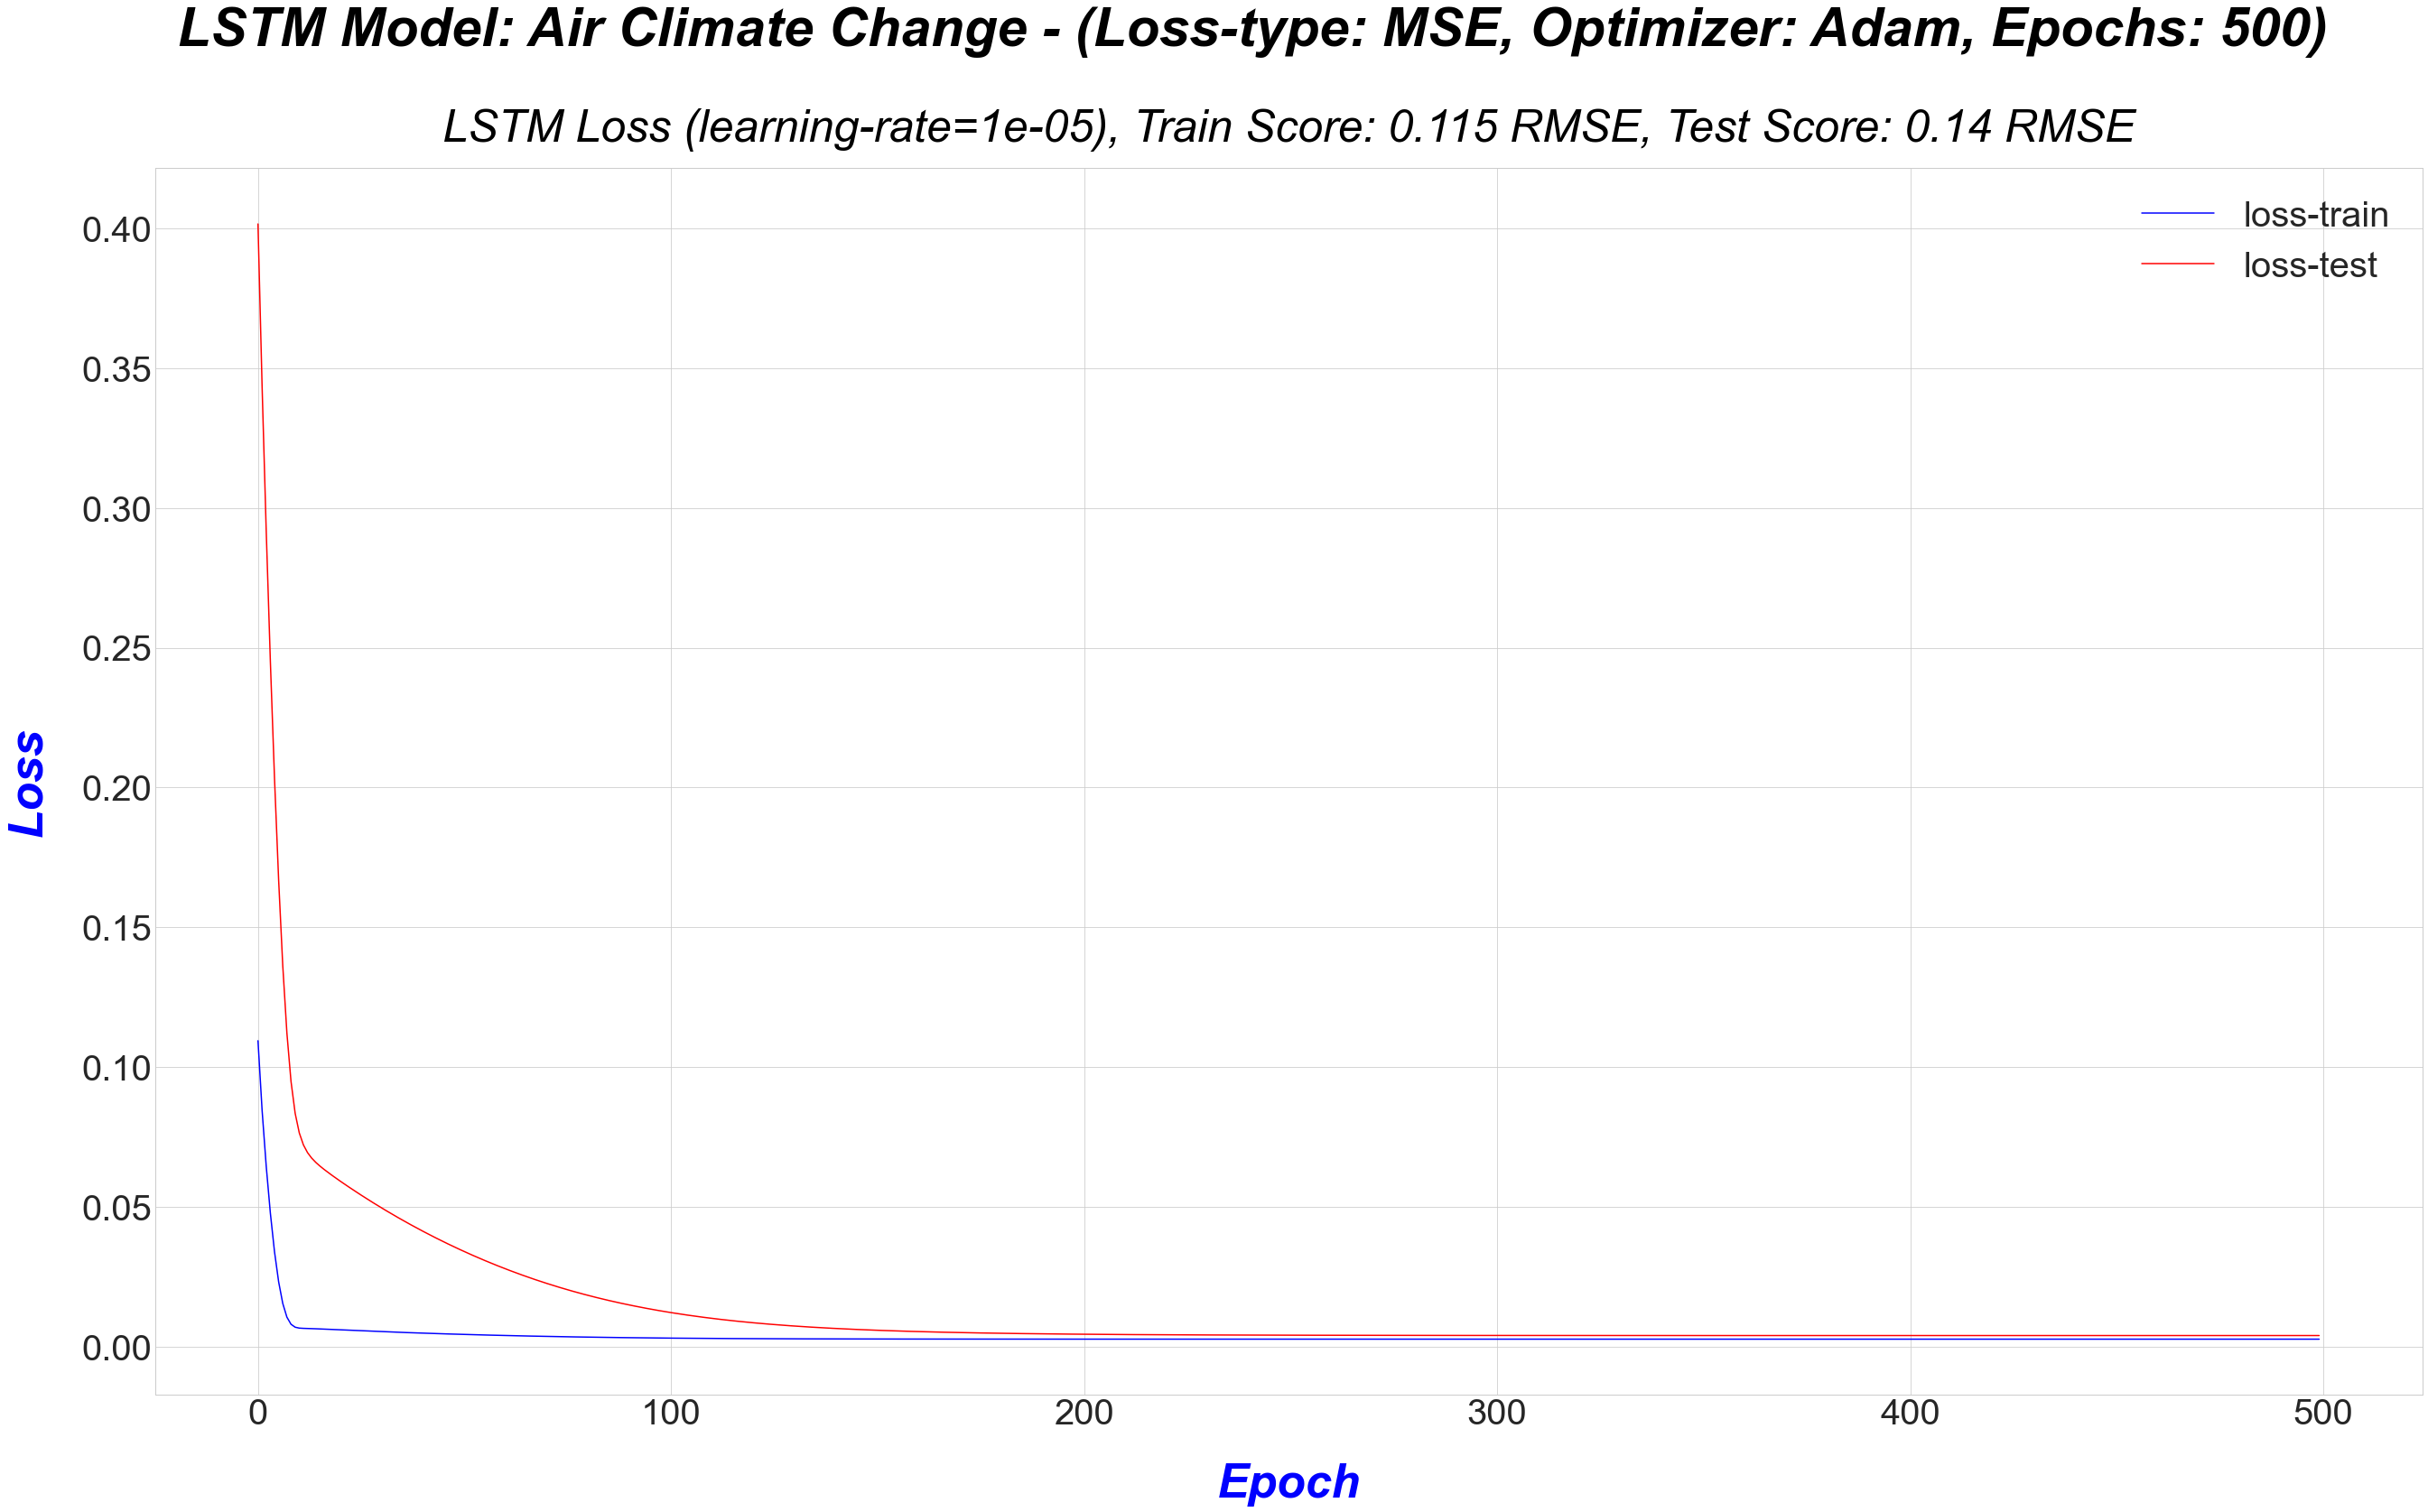

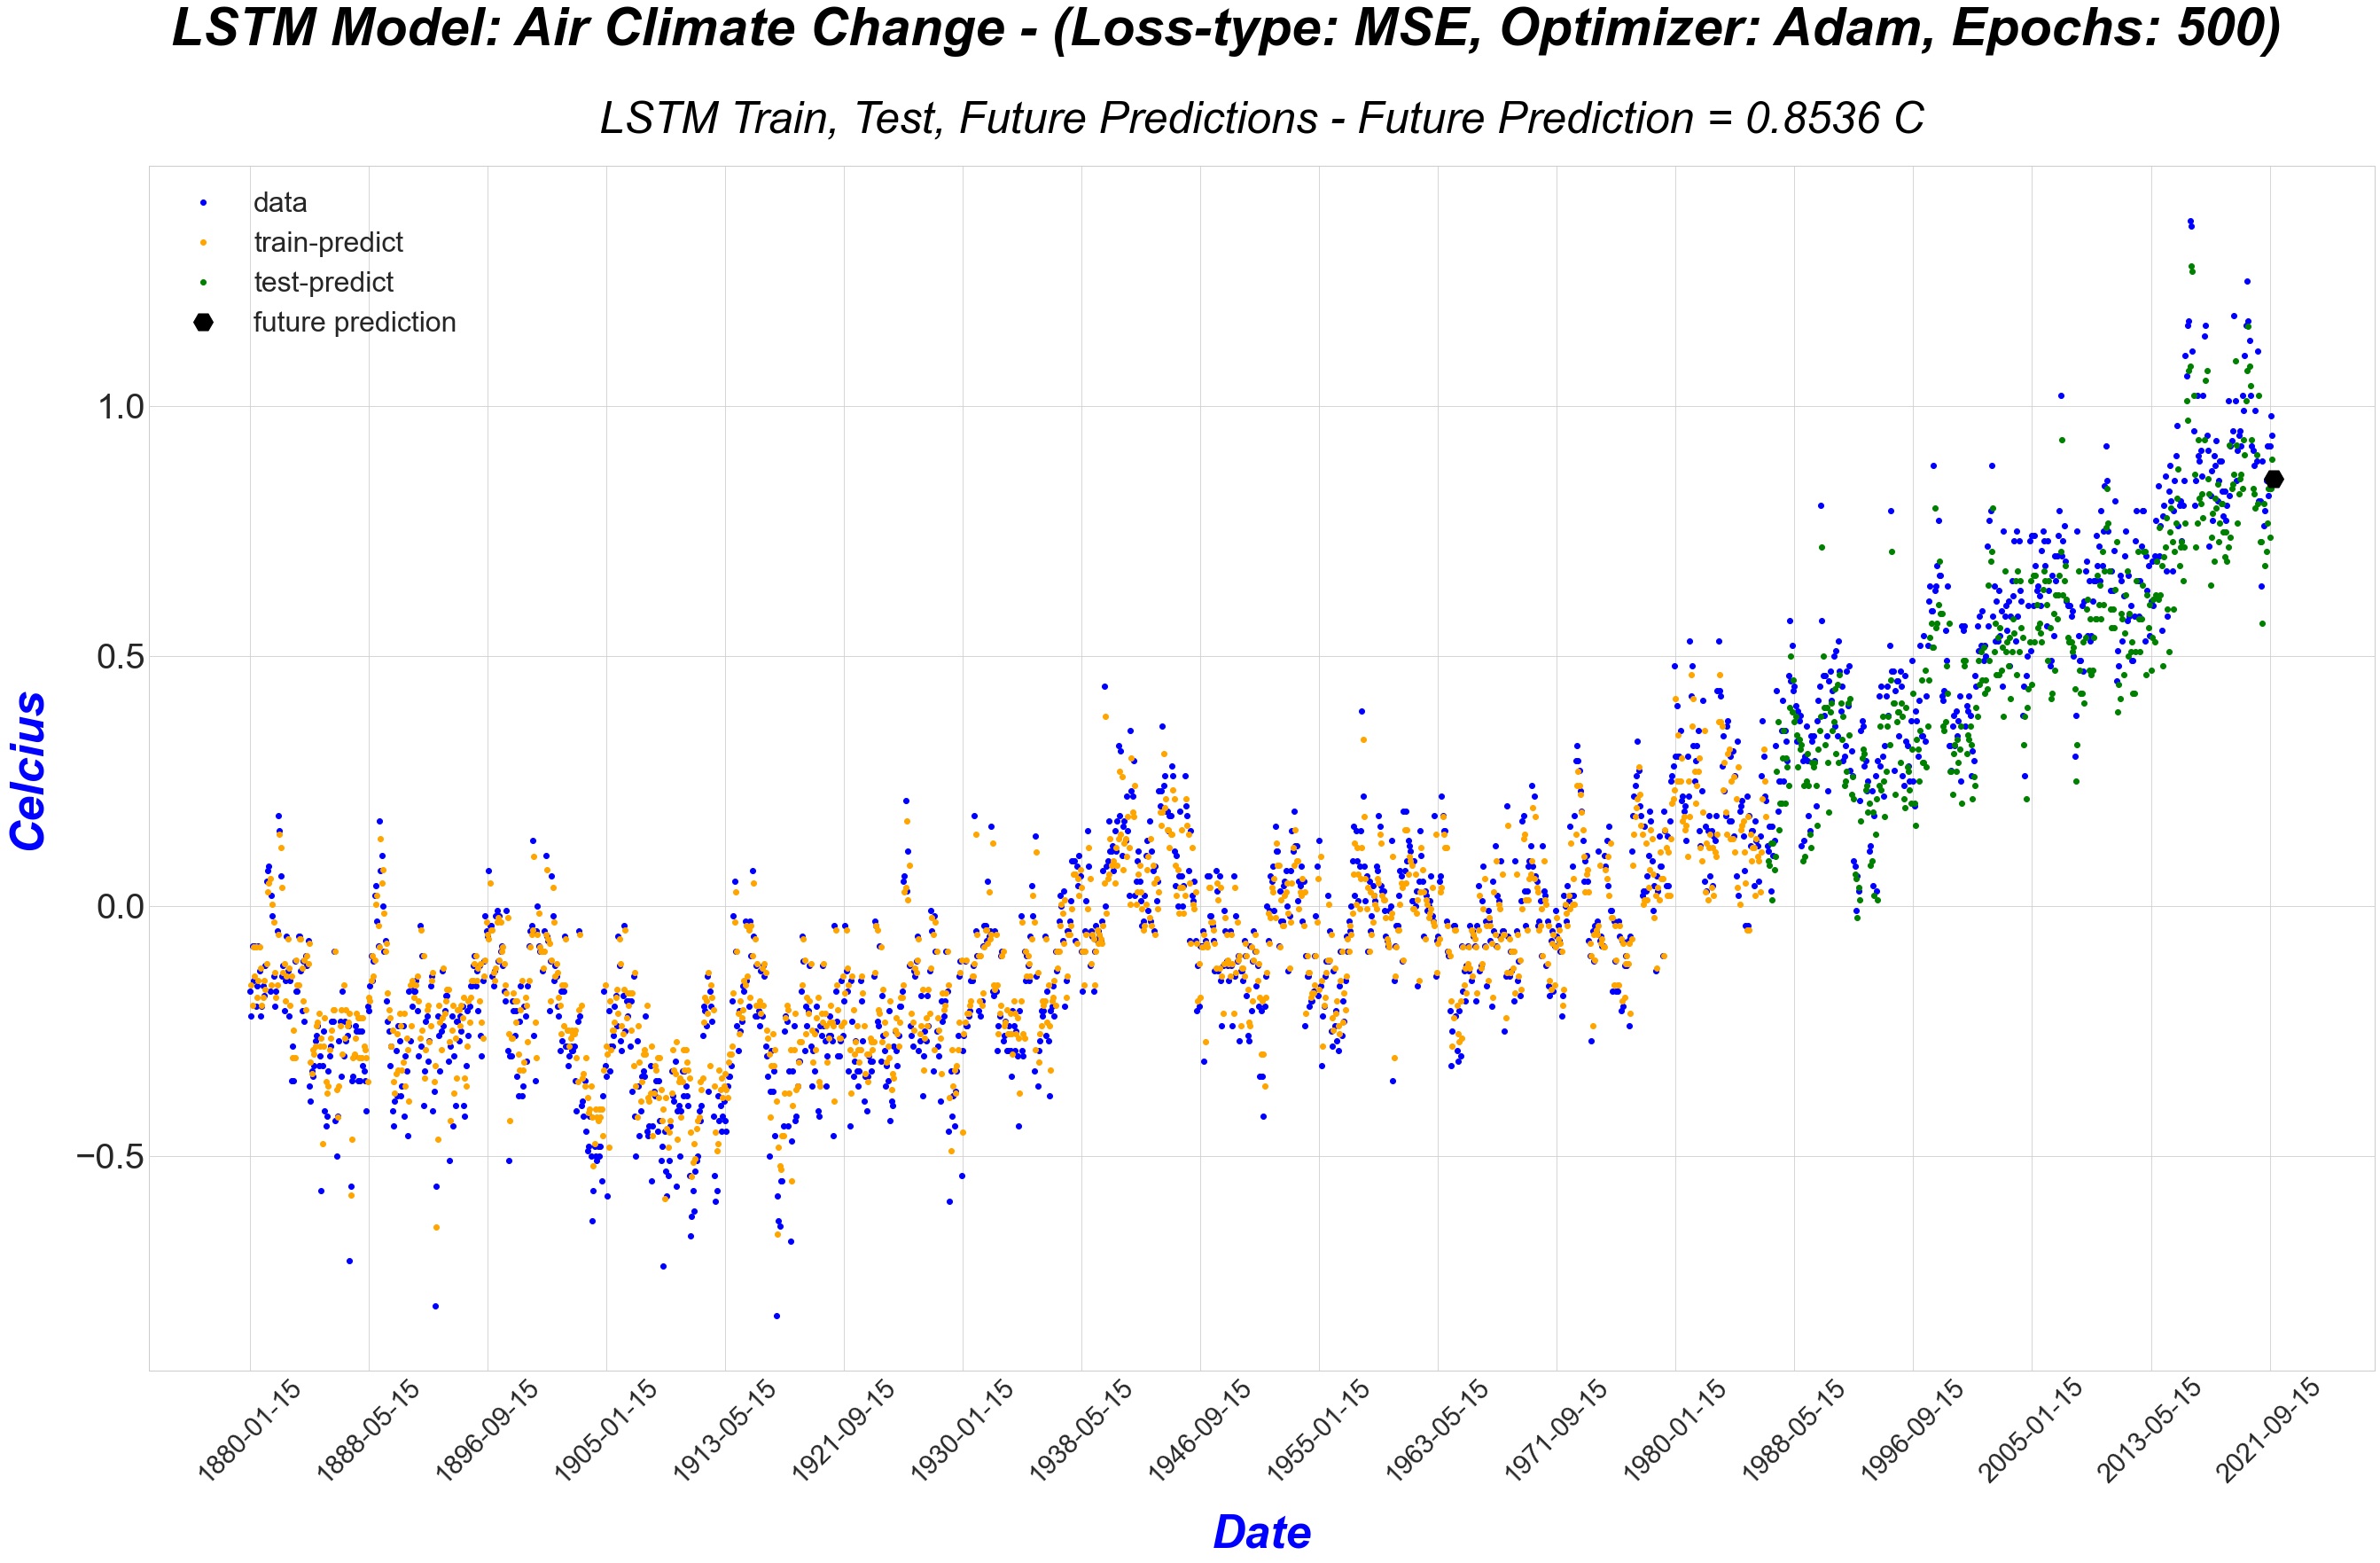

In [19]:
#
# Plot for non-stacked model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict
    
futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_nonstacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_nonstacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_nonstacked_lstm.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-nonstacked-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-nonstacked-plot.png")
plt.show();

## **Run the Stacked model**

In [20]:
#
# Stacked layer LSTM
#

lrate = 0.00001
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 500

history_stacked_lstm, lstm_stacked_model = create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, 1)
lstm_stacked_model.save('./models/lstm_stacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_stacked_model.predict(trainX)
testPredict = lstm_stacked_model.predict(testX)
    
#
# Make next time period prediction
#
print("Last Entry:")
print(last_entry)
future_prediction = lstm_stacked_model.predict(last_entry, batch_size=30)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_stacked_lstm = lstm_stacked_model.evaluate(testX, testY, verbose=1)
print("Stacked Model Score:")
print(score_stacked_lstm)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 1, 20)             1760      
                                                                 
 layer2 (LSTM)               (None, 20)                3280      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1276/1276 [==============================] - 5s 2ms/step - loss: 0.0995 - accuracy: 7.8370e-04 - val_loss: 0.3696 - val_accuracy: 0.0000e+00
Epoch 2/500
1276/1276 [==============================] - 2s 2ms/step - loss: 0.0743 - accuracy: 7.8370e-04 - val_loss: 0.3102 - val_accuracy: 0.0000e+00
Epoch 3/50

INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


Last Entry:
[[[0.8036529]]]
Future Prediction scaled: [[0.787595]]
Future Prediction unscaled: [[0.9048331]]

Train Score: 0.12 RMSE
Test Score: 0.13 RMSE
14/14 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.0024
Stacked Model Score:
[0.003549395129084587, 0.002352941082790494]


## **Plot the Stacked Model**

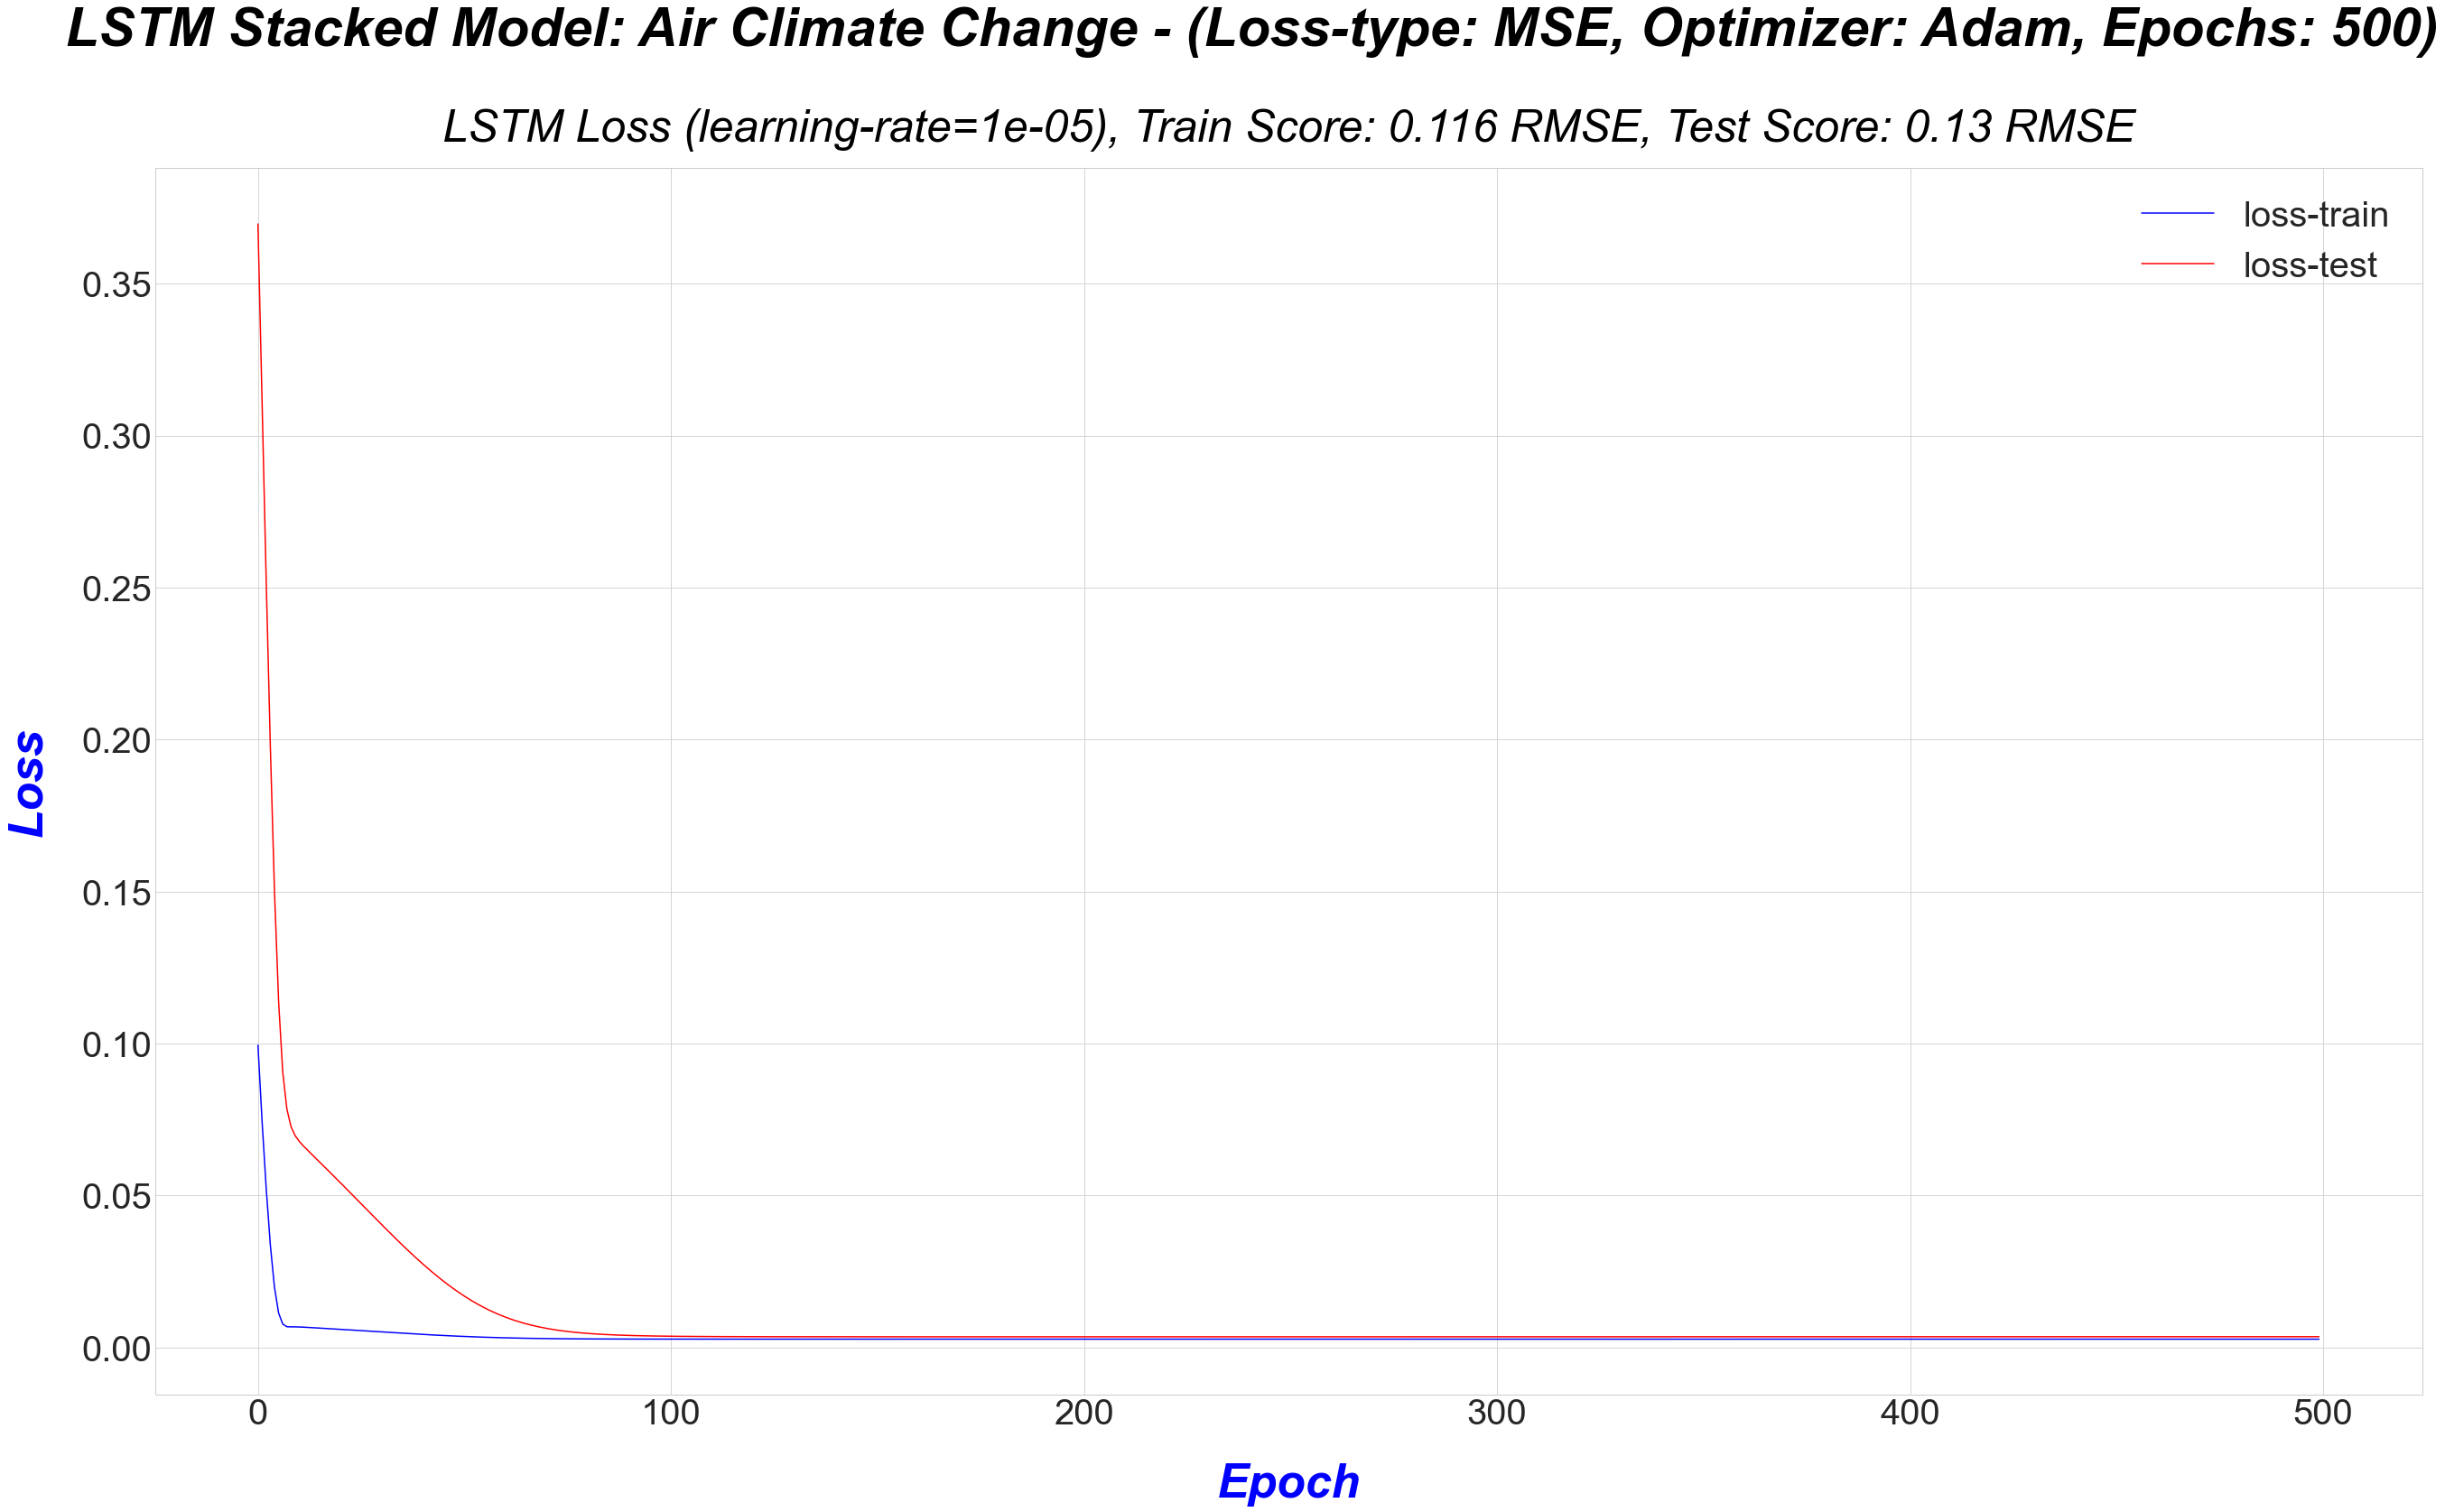

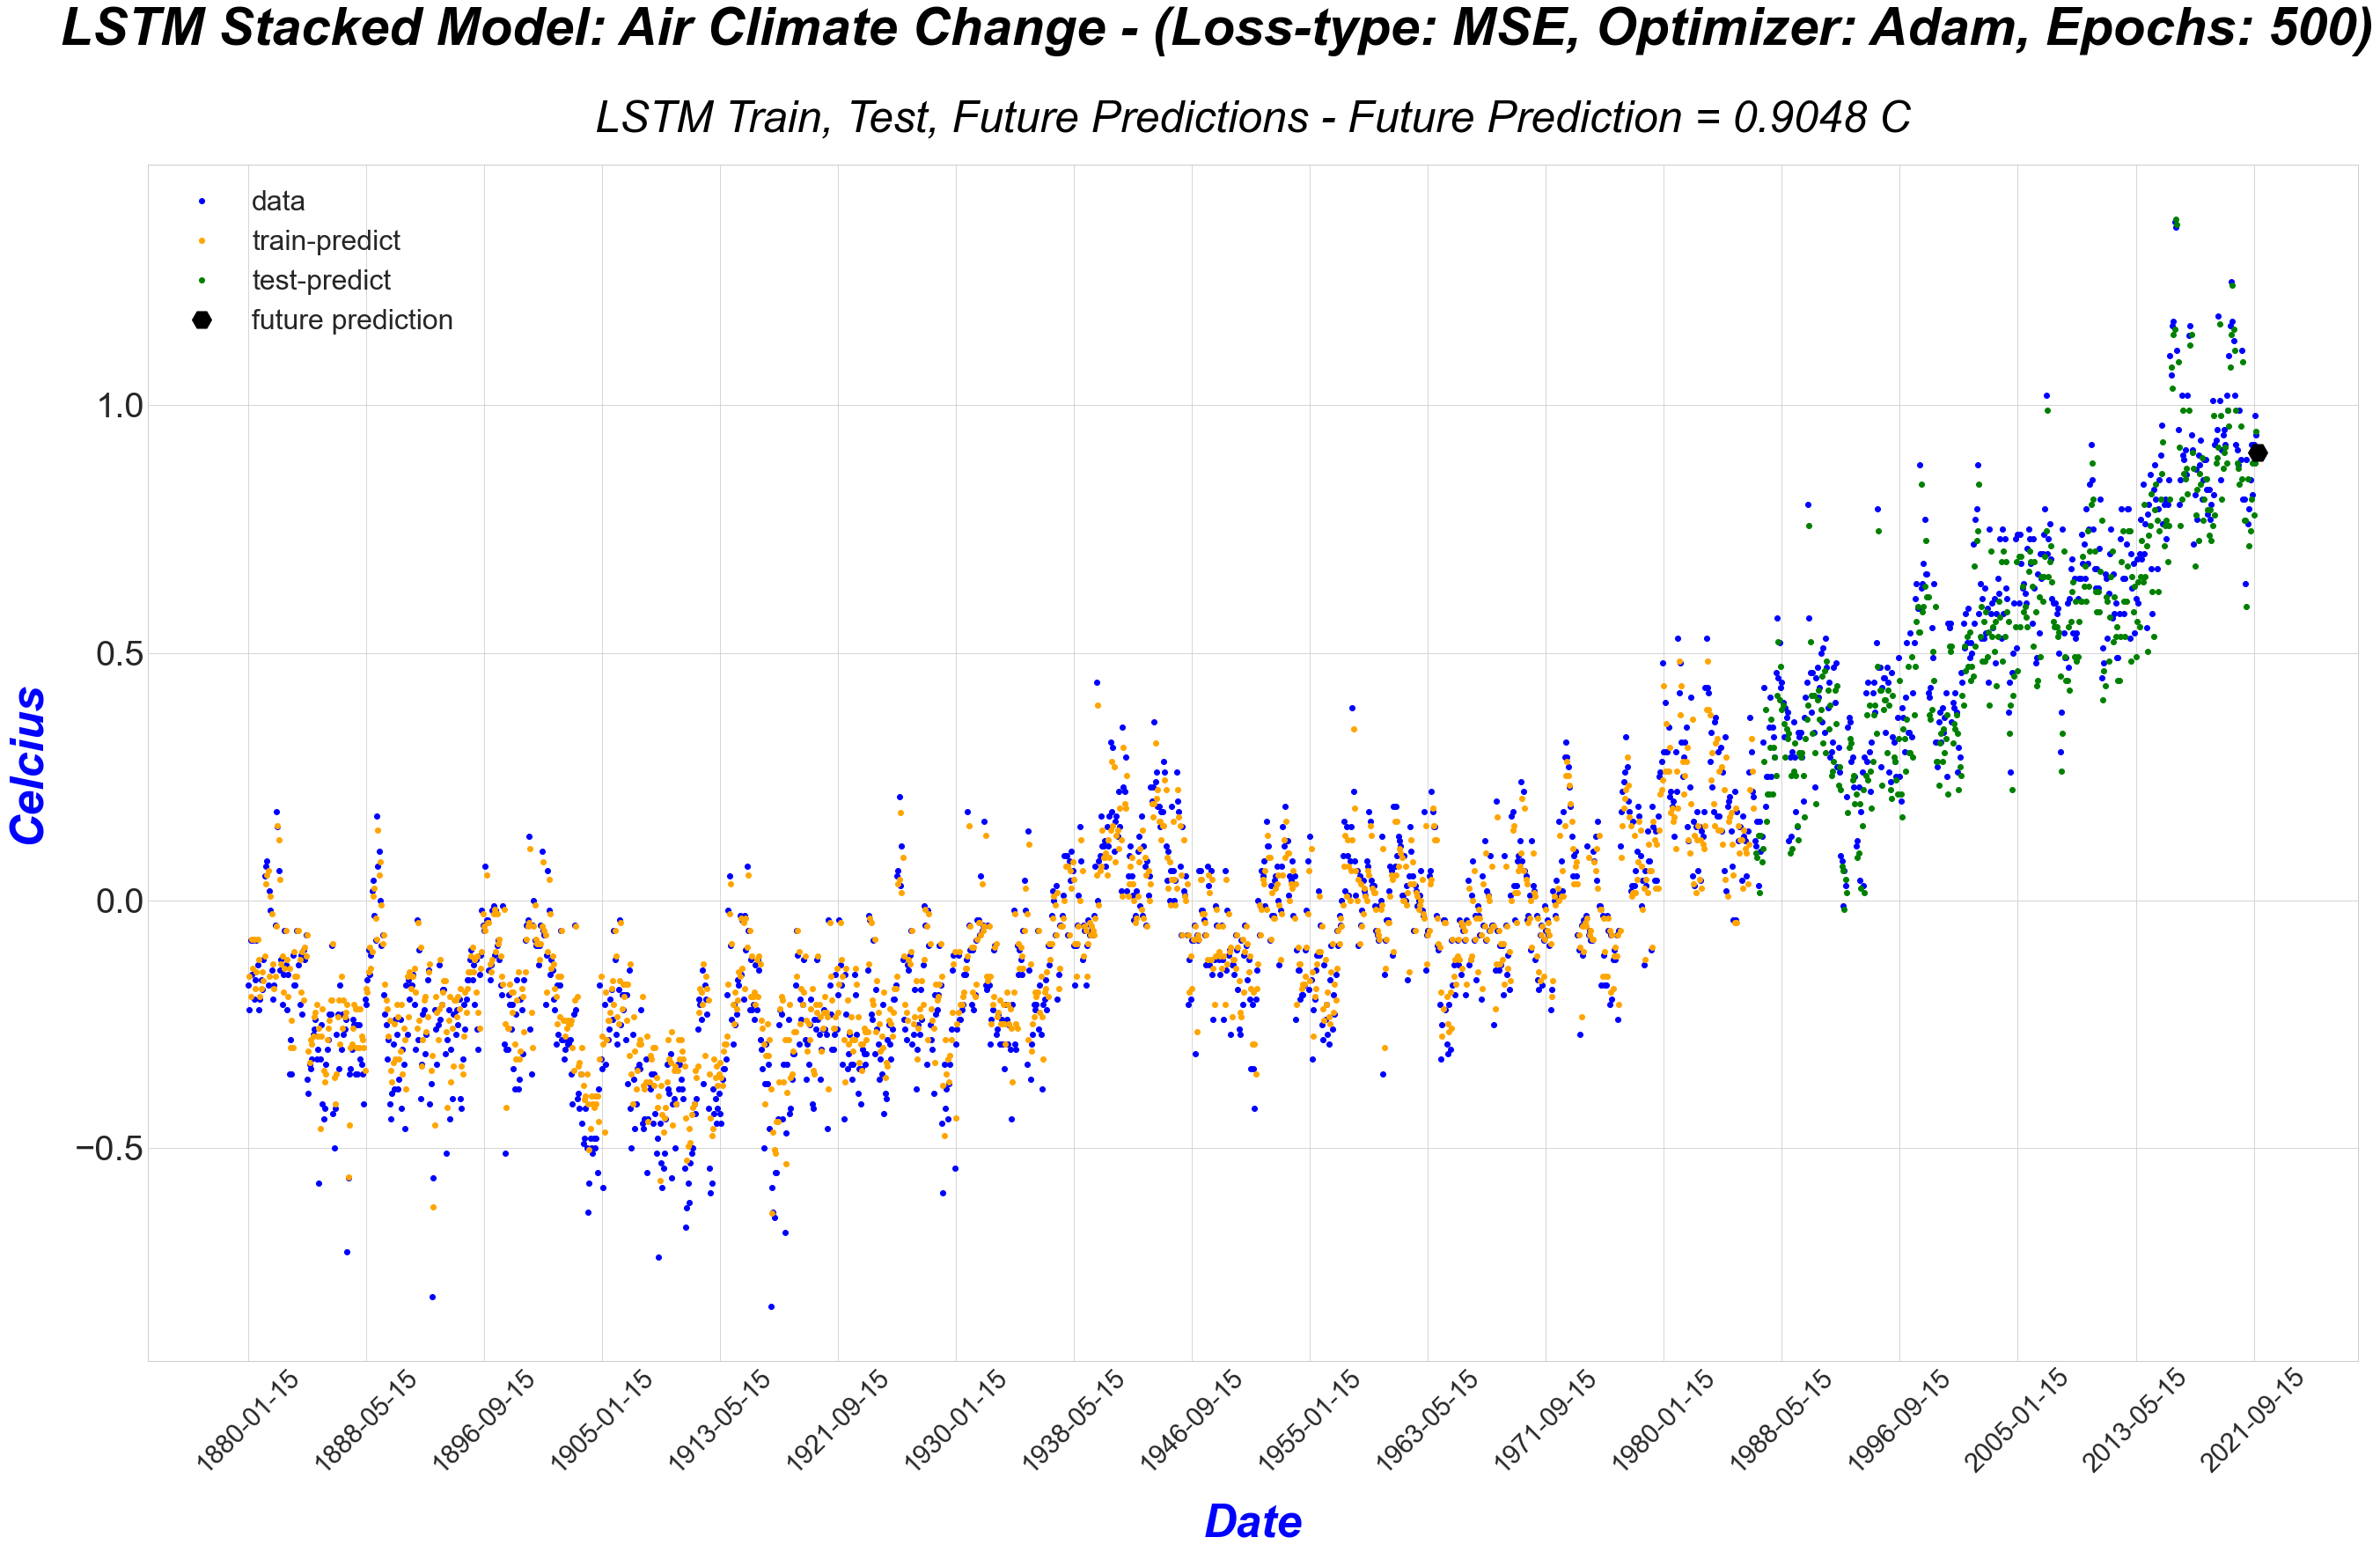

In [21]:
#
# Plot for stacked LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict

futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_stacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_stacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_stacked_lstm.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-plot.png")
plt.show();

## **Run the bidirectional model**

In [22]:
#
# Bidirectional layer LSTM
#

lrate = 0.00001
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 500

history_bidirectional_lstm, lstm_bidirectional_model = create_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, 1)
lstm_bidirectional_model.save('./models/lstm_bidirectional_model_1')
    
#
# Predictions
#
trainPredict = lstm_bidirectional_model.predict(trainX)
testPredict = lstm_bidirectional_model.predict(testX)
    
#
# Make next time period prediction
#
print("Last Entry:")
print(last_entry)
future_prediction = lstm_bidirectional_model.predict(last_entry, batch_size=30)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_bidirectional_lstm = lstm_bidirectional_model.evaluate(testX, testY, verbose=1)
print("Bidirectional Model Score:")
print(score_bidirectional_lstm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Bidirectional)      (None, 40)                3520      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1276/1276 [==============================] - 3s 1ms/step - loss: 0.1172 - accuracy: 7.8370e-04 - val_loss: 0.4361 - val_accuracy: 0.0000e+00
Epoch 2/500
1276/1276 [==============================] - 1s 1ms/step - loss: 0.0958 - accuracy: 7.8370e-04 - val_loss: 0.3865 - val_accuracy: 0.0000e+00
Epoch 3/500
1276/1276 [==============================] - 1s 1ms/step - loss: 0.0789 - accuracy: 7.8370e-04 - val_loss: 0.3426 - val_accuracy: 

INFO:tensorflow:Assets written to: ./models/lstm_bidirectional_model_1/assets


Last Entry:
[[[0.8036529]]]
Future Prediction scaled: [[0.7786309]]
Future Prediction unscaled: [[0.8852018]]

Train Score: 0.11 RMSE
Test Score: 0.13 RMSE
14/14 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.0024
Bidirectional Model Score:
[0.0037136615719646215, 0.002352941082790494]


## **Plot the Bidirectional Model**

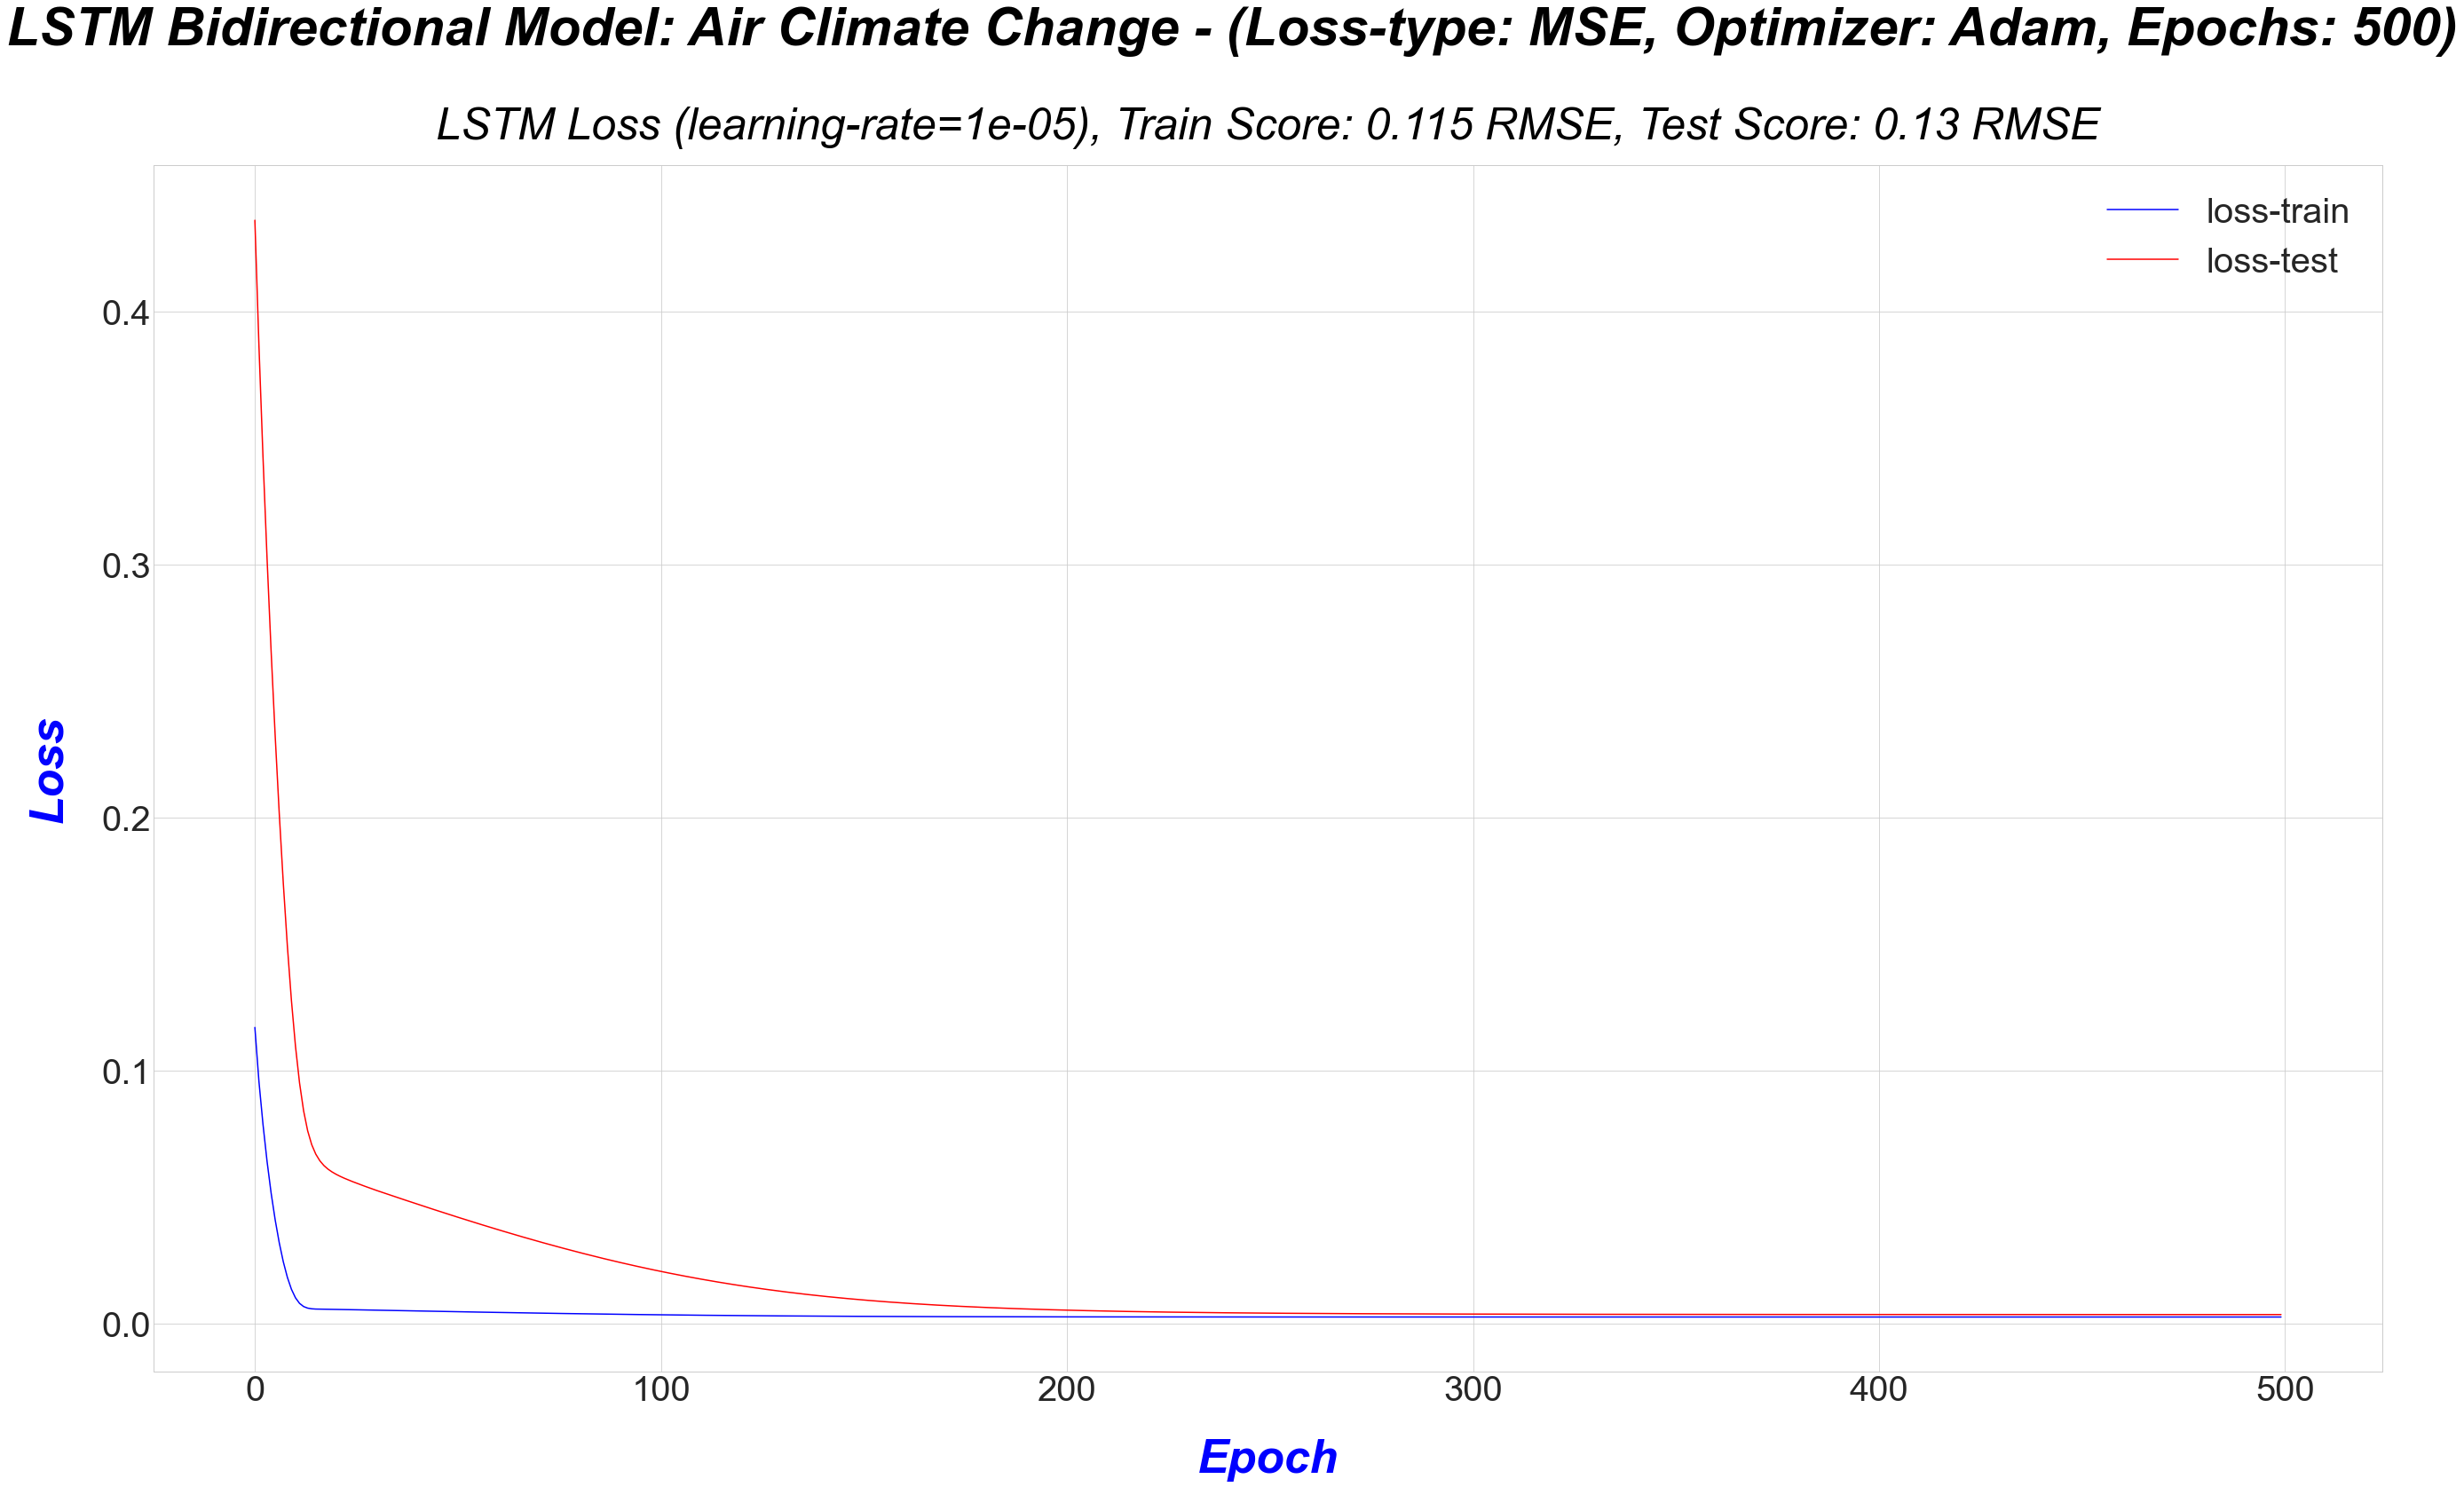

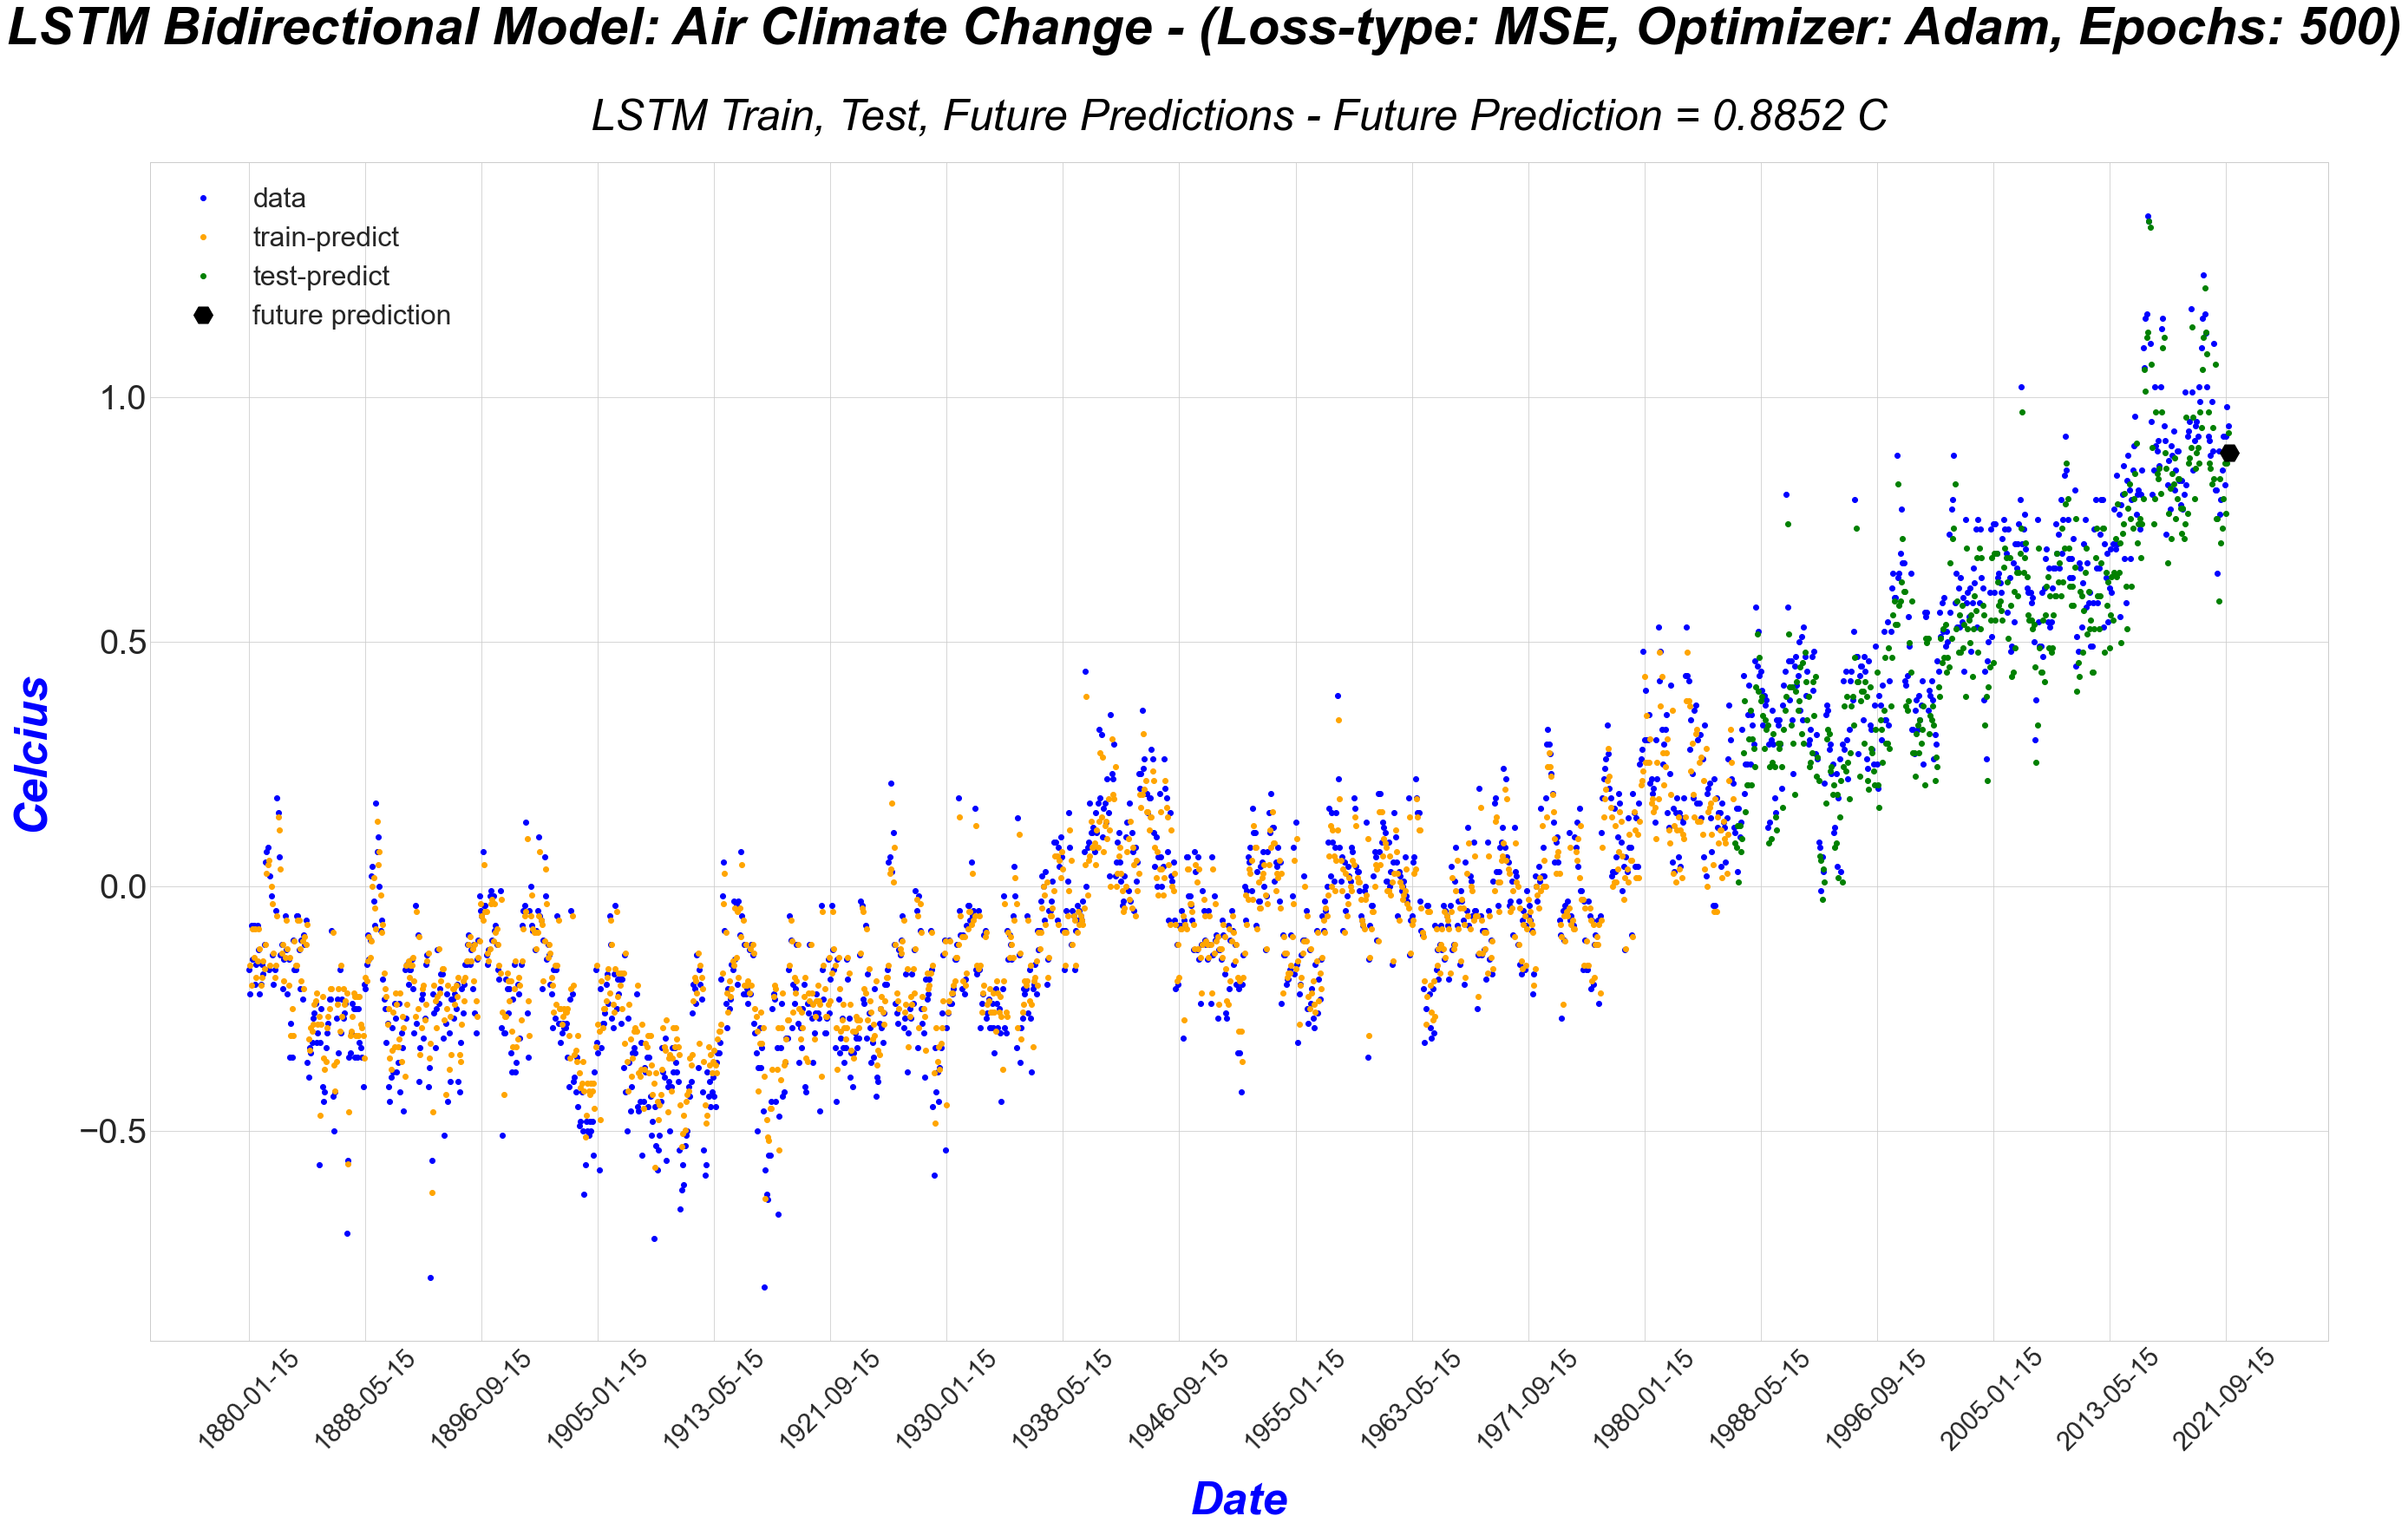

In [23]:
#
# Plot for bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict   

futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_bidirectional_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_bidirectional_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_bidirectional_lstm.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-bidirectional-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-bidirectional-plot.png")
plt.show();

<br>

# **Create Main Climate Change Dataframe**
### Using all dataset csv files

In [62]:
#
# Apply method for each dataset's dataframe
#
def update_master_df(row):
   
    global df_main
    
    if row['Country Code'] != 'WLD':
        return
    
    #country = row['Country Code']
    code = row['Indicator Code']
    
    d = []
    
    for y in range(1960, 2021, 1):
        if str(y) in row:
            d.append(row[str(y)])
        else:
            d.append(float("NaN"))
    
    df_main[code] = d

      

file_names = [
    'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3053855.csv',     # Access to electricity (% of population) EG.ELC.ACCS.ZS
    'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3052884.csv',     # Agricultural land (% of land area) AG.LND.AGRI.ZS
    'API_AG.LND.ARBL.ZS_DS2_en_csv_v2_3054826.csv',     # Arable land (% of land area) AG.LND.ARBL.ZS
    'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3053008.csv',     # CO2 emissions (metric tons per capita) EN.ATM.CO2E.PC
    'API_AG.YLD.CREL.KG_DS2_en_csv_v2_3053734.csv',     # Cereal yield (kg per hectare) AG.YLD.CREL.KG
    'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3052822.csv',  # Electric power consumption (kWh per capita) EG.USE.ELEC.KH.PC
    'API_AG.LND.FRST.ZS_DS2_en_csv_v2_3052585.csv',     # Forest area (% of land area) AG.LND.FRST.ZS
    'API_AG.LND.EL5M.ZS_DS2_en_csv_v2_3057029.csv',     # Land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS
    'API_SH.DYN.MORT_DS2_en_csv_v2_3058030.csv',        # Mortality rate, under-5 (per 1,000 live births) SH.DYN.MORT
    'API_SP.POP.GROW_DS2_en_csv_v2_3052790.csv',        # Population growth (annual %) SP.POP.GROW
    'API_EN.POP.EL5M.ZS_DS2_en_csv_v2_3057452.csv',     # Population living in areas where elevation is below 5 meters (% of total population) EN.POP.EL5M.ZS
    'API_SI.POV.DDAY_DS2_en_csv_v2_3055766.csv',        # Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) SI.POV.DDAY
    'API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_3053767.csv',     # Primary completion rate, total (% of relevant age group) SE.PRM.CMPT.ZS
    'API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3053509.csv',     # Renewable energy consumption (% of total final energy consumption) EG.FEC.RNEW.ZS
    'API_SP.URB.TOTL_DS2_en_csv_v2_3058363.csv',        # Urban population SP.URB.TOTL
    'API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_3052981.csv',     # Agriculture, forestry, and fishing, value added (% of GDP) NV.AGR.TOTL.ZS
    'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3052647.csv',     # CO2 emissions (kt) EN.ATM.CO2E.KT
    'API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_3052915.csv',  # Energy use (kg of oil equivalent per capita) EG.USE.PCAP.KG.OE
    'API_AG.LND.FRST.K2_DS2_en_csv_v2_3054052.csv',     # Forest area (sq. km) AG.LND.FRST.K2
    'API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3052859.csv',  # Methane emissions (kt of CO2 equivalent) EN.ATM.METH.KT.CE
    'API_EN.ATM.NOXE.KT.CE_DS2_en_csv_v2_3054894.csv',  # Nitrous oxide emissions (thousand metric tons of CO2 equivalent) EN.ATM.NOXE.KT.CE
    'API_EN.URB.MCTY.TL.ZS_DS2_en_csv_v2_3053950.csv',  # Population in urban agglomerations of more than 1 million (% of total population) EN.URB.MCTY.TL.ZS
    'API_SP.POP.TOTL_DS2_en_csv_v2_3052518.csv',        # Population, total SP.POP.TOTL
    'API_SH.STA.MALN.ZS_DS2_en_csv_v2_3058087.csv',     # Prevalence of underweight, weight for age (% of children under 5) SH.STA.MALN.ZS
    'API_EG.ELC.RNEW.ZS_DS2_en_csv_v2_3054878.csv',     # Renewable electricity output (% of total electricity output) EG.ELC.RNEW.ZS
    'API_SE.ENR.PRSC.FM.ZS_DS2_en_csv_v2_3057870.csv',  # School enrollment, primary and secondary (gross), gender parity index (GPI) SE.ENR.PRSC.FM.ZS
    'API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_3052850.csv',  # Total greenhouse gas emissions (kt of CO2 equivalent) EN.ATM.GHGT.KT.CE
    'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_3053985.csv'   # Urban population (% of total population) SP.URB.TOTL.IN.ZS
]


#
# Main dataframe to work off of
#

df_main = pd.DataFrame(columns=['year'])
df_main['year'] = [
    1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
    1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
    2020
]


#
# Loop through each dataset and add it to the main dataframe
#
c = 0
df_collection = {}
for f in file_names:
    _df = pd.read_csv(data_dir + f)
    _df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    _df.drop(_df.columns[_df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
    df_collection[c] = _df
    _df.apply(update_master_df, axis=1)             
    c += 1

#pd.set_option("display.max_rows", None, "display.max_columns", None)
df_main.head(65)  

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1960,NaN,NaN,NaN,3.121158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.130853,3.032156e+09,NaN,NaN,NaN,NaN,33.617972
1,1961,NaN,35.965095,9.656792,3.068090,1428.405939,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.400146,3.071596e+09,NaN,NaN,NaN,NaN,34.115490
2,1962,NaN,36.044180,9.668757,3.114839,1518.828776,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.589890,3.124561e+09,NaN,NaN,NaN,NaN,34.557149
3,1963,NaN,36.146651,9.756626,3.221195,1583.640114,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.729545,3.189656e+09,NaN,NaN,NaN,NaN,34.943734
4,1964,NaN,36.236356,9.785195,3.324046,1585.371387,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.884439,3.255146e+09,NaN,NaN,NaN,NaN,35.336154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2016,87.714456,36.701221,10.764754,4.436759,4009.231276,NaN,30.716421,NaN,41.3,...,39958245.9,8068580.0,2934600.0,23.538567,7.424485e+09,13.732595,NaN,1.00006,44550150.0,54.370833
57,2017,88.602034,37.008413,10.831252,4.441309,4114.052902,NaN,NaN,NaN,40.0,...,NaN,8137390.0,2986520.0,23.765917,7.509410e+09,13.416059,NaN,0.99759,45117640.0,54.823831
58,2018,89.419014,36.903521,10.825170,4.483524,4070.667048,NaN,NaN,NaN,38.8,...,NaN,8174420.0,2984340.0,24.008219,7.592476e+09,13.133182,NaN,0.98576,45873850.0,55.271710
59,2019,90.084031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,...,NaN,NaN,NaN,24.216891,7.673345e+09,12.864292,NaN,0.98637,NaN,55.714433


In [63]:
#
# Add the beginning years (1880 to 1959) for which there are temperature data but no data for the other datasets
#

for i in range(1959, 1879, -1):
    df_main.loc[-1] = [i, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
    df_main.index = df_main.index + 1
    df_main = df_main.sort_index()

In [64]:
# df_main

In [65]:
#
# Make 12 copies for each row. The termperature dataset comes in 12 data points per year and the other datasets provide one data point per year
# Just copy the row 12 times as a best approximation
#

#for i in range(0, 69):
df_main = df_main.loc[df_main.index.repeat(12)]
df_main = df_main.sort_index()
df_main.reset_index(drop=True, inplace=True)

In [66]:
df_main.head(65)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#
# Convert all 'year' values from 1980.0 to '1980-01-15', etc
# Use the index mod by 12 to determine what month it should be. The day is always set to 15
#

df_main['year'] = df_main['year'].astype('int64')

def fix_dates(row):
    idx = int(row.name)
    month = (idx % 12) + 1
    month = f'{month:02d}'
    row['year'] = str(int(row['year'])) + '-' + str(month) + '-15'
    # print(row.name)
    return row

new_df = df_main.apply(fix_dates, axis=1)

In [68]:
new_df.rename(columns={'year': 'Day'}, inplace=True)

new_df.head(65)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1885-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1885-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1885-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1885-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
#
# Fill in the missing rows at the end where the datasets do not have the same length as the temperature datasets
# (Temperature goes up to Nov 2021, other datasets end at Dec 2020)
#

new_df.loc[len(new_df.index)] = ['2021-01-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-02-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-03-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-04-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-05-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-06-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-07-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-08-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-09-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-10-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
new_df.loc[len(new_df.index)] = ['2021-11-15', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [70]:
# This number should equal the same as the original dataframe in length

print("These two datafame lengths should now be equal so they can be joined:")
print(len(new_df))
print(len(master_df))

These two datafame lengths should now be equal so they can be joined:
1703
1703


In [71]:
#
# Create the final dataframe by merging the original saved at the beginning and the newly dataframe just created
#

final_df = pd.merge(master_df, new_df, on="Day")

In [72]:
#
# Fill in all NaN values with -1 so that these values can be masked during the model fit
#

final_df.fillna(-1, inplace=True)
final_df.head()

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,-0.17,-0.2283,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1880-02-15,-0.22,-0.1353,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1880-03-15,-0.08,-0.0102,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1880-04-15,-0.15,-0.1158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1880-05-15,-0.08,-0.3387,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [73]:
print("Final Columns:")
final_df.columns

Final Columns:


Index(['Day', 'world_air_temperature_anomaly', 'world_sea_temperature_anomaly',
       'EG.ELC.ACCS.ZS', 'AG.LND.AGRI.ZS', 'AG.LND.ARBL.ZS', 'EN.ATM.CO2E.PC',
       'AG.YLD.CREL.KG', 'EG.USE.ELEC.KH.PC', 'AG.LND.FRST.ZS',
       'AG.LND.EL5M.ZS', 'SH.DYN.MORT', 'SP.POP.GROW', 'EN.POP.EL5M.ZS',
       'SI.POV.DDAY', 'SE.PRM.CMPT.ZS', 'EG.FEC.RNEW.ZS', 'SP.URB.TOTL',
       'NV.AGR.TOTL.ZS', 'EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE',
       'AG.LND.FRST.K2', 'EN.ATM.METH.KT.CE', 'EN.ATM.NOXE.KT.CE',
       'EN.URB.MCTY.TL.ZS', 'SP.POP.TOTL', 'SH.STA.MALN.ZS', 'EG.ELC.RNEW.ZS',
       'SE.ENR.PRSC.FM.ZS', 'EN.ATM.GHGT.KT.CE', 'SP.URB.TOTL.IN.ZS'],
      dtype='object')

In [74]:
#
# Create a seperate Series for each of the dataframe's columns
#

col1 = final_df['world_air_temperature_anomaly'].values
col2 = final_df['world_sea_temperature_anomaly'].values

col3 = final_df['EG.ELC.ACCS.ZS'].values
col4 = final_df['AG.LND.AGRI.ZS'].values
col5 = final_df['AG.LND.ARBL.ZS'].values
col6 = final_df['EN.ATM.CO2E.PC'].values

col7 = final_df['AG.YLD.CREL.KG'].values
col8 = final_df['EG.USE.ELEC.KH.PC'].values
col9 = final_df['AG.LND.FRST.ZS'].values

col10 = final_df['AG.LND.EL5M.ZS'].values
col11 = final_df['SH.DYN.MORT'].values
col12 = final_df['SP.POP.GROW'].values
col13 = final_df['EN.POP.EL5M.ZS'].values

col14 = final_df['SI.POV.DDAY'].values
col15 = final_df['SE.PRM.CMPT.ZS'].values
col16 = final_df['EG.FEC.RNEW.ZS'].values
col17 = final_df['SP.URB.TOTL'].values

col18 = final_df['NV.AGR.TOTL.ZS'].values
col19 = final_df['EN.ATM.CO2E.KT'].values
col20 = final_df['EG.USE.PCAP.KG.OE'].values

col21 = final_df['AG.LND.FRST.K2'].values
col22 = final_df['EN.ATM.METH.KT.CE'].values
col23 = final_df['EN.ATM.NOXE.KT.CE'].values

col24 = final_df['EN.URB.MCTY.TL.ZS'].values
col25 = final_df['SP.POP.TOTL'].values
col26 = final_df['SH.STA.MALN.ZS'].values
col27 = final_df['EG.ELC.RNEW.ZS'].values

col28 = final_df['SE.ENR.PRSC.FM.ZS'].values
col29 = final_df['EN.ATM.GHGT.KT.CE'].values
col30 = final_df['SP.URB.TOTL.IN.ZS'].values

In [75]:
#
# Reshape all of the column Series
#

col1 = col1.reshape((len(col1), 1))
col2 = col2.reshape((len(col2), 1))
col3 = col3.reshape((len(col3), 1))
col4 = col4.reshape((len(col4), 1))
col5 = col5.reshape((len(col5), 1))
col6 = col6.reshape((len(col6), 1))
col7 = col7.reshape((len(col7), 1))
col8 = col8.reshape((len(col8), 1))
col9 = col9.reshape((len(col9), 1))
col10 = col10.reshape((len(col10), 1))
col11 = col11.reshape((len(col11), 1))
col12 = col12.reshape((len(col12), 1))
col13 = col13.reshape((len(col13), 1))
col14 = col14.reshape((len(col14), 1))
col15 = col15.reshape((len(col15), 1))
col16 = col16.reshape((len(col16), 1))
col17 = col17.reshape((len(col17), 1))
col18 = col18.reshape((len(col18), 1))
col19 = col19.reshape((len(col19), 1))
col20 = col20.reshape((len(col20), 1))
col21 = col21.reshape((len(col21), 1))
col22 = col22.reshape((len(col22), 1))
col23 = col23.reshape((len(col23), 1))
col24 = col24.reshape((len(col24), 1))
col25 = col25.reshape((len(col25), 1))
col26 = col26.reshape((len(col26), 1))
col27 = col27.reshape((len(col27), 1))
col28 = col28.reshape((len(col28), 1))
col29 = col29.reshape((len(col29), 1))
col30 = col30.reshape((len(col30), 1))

In [76]:
#
# Shift the input column by one to create the output column
#

def shift_by_1(arr, num, fill_value=np.nan):
    arr = np.roll(arr, num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

out_col = shift_by_1(col1, -1)
# out_col

In [77]:
out_col

array([[-0.22],
       [-0.08],
       [-0.15],
       ...,
       [ 0.98],
       [ 0.94],
       [  nan]])

In [78]:
#
# Horizontal stack the reshaped columns INCLUDING the output column (out_col)
#

ds = np.hstack((col1, col2, col3, col4, col5, col6, col7, col8, col9, col10,
                col11, col12, col13, col14, col15, col16, col17, col18, col19, col20,
                col21, col22, col23, col24, col25, col26, col27, col28, col29, col30,
                out_col))

print("There should be 1703 rows and 31 features now:")
ds.shape

There should be 1703 rows and 31 features now:


(1703, 31)

In [79]:
#
# Setup MinMax Scaler for the entire dataset
#

np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)
#print(scaler.min_, scaler.scale_)

#
# Split a multivariate sequence into samples
# Assumes the Y column is the last column !!!
#
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

n_steps = 1

X, y = split_sequences(ds, n_steps)
n_features = X.shape[2]

print(X.shape)  # Rows, steps, columns

(1703, 1, 30)


In [81]:
ds

array([[0.29680365, 0.33087819, 0.        , ..., 0.        , 0.        ,
        0.2739726 ],
       [0.2739726 , 0.38942398, 0.        , ..., 0.        , 0.        ,
        0.33789954],
       [0.33789954, 0.46817753, 0.        , ..., 0.        , 0.        ,
        0.30593607],
       ...,
       [0.79452055, 0.92326094, 0.        , ..., 0.        , 0.        ,
        0.82191781],
       [0.82191781, 0.9095373 , 0.        , ..., 0.        , 0.        ,
        0.80365297],
       [0.80365297, 0.90349386, 0.        , ..., 0.        , 0.        ,
               nan]])

In [82]:
# print(scaler.min_, scaler.scale_)

In [83]:
#
# Create a new scaler that can be used for a one column numpy array
# The initial data was scaled by all columns so there are 31 values for min_, scale_, etc
# We only need the first values to descale the output values
#

# The first min_ and scale_ values from the original MinMaxScaler
new_scaler = MinMaxScaler()
new_scaler.min_, new_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

In [84]:
look_back = 1  # Don't need this value but just a reminder the window is size 1

train_size = int(len(ds) * 0.75)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds),:]

trainX = X[0:train_size,:]
trainY = y[0:train_size:]

testX = X[train_size:len(X),:]
testY = y[train_size:len(y):]

testX = testX[:-1]
testY = testY[:-1]

print("trainX.shape:")
print(trainX.shape)
print()
print("trainY.shape:")
print(trainY.shape)
print()
print("textX.shape:")
print(testX.shape)
print()
print("testY.shape:")
print(testY.shape)
print()

trainX.shape:
(1277, 1, 30)

trainY.shape:
(1277,)

textX.shape:
(425, 1, 30)

testY.shape:
(425,)



In [52]:
lrate = 0.00001
loss_type = 'mean_squared_error'
num_epochs = 500
batch_size = 1

main_model = Sequential([
    Masking(mask_value=-1, input_shape=(n_steps, n_features)),
    Bidirectional(LSTM(40), name='layer1'),  # recurrent_dropout=0.10),
    # Dropout(0.2),
    Dense(1, name='Output')
])

opt = Adam(learning_rate=lrate)

main_model.compile(optimizer=opt, loss=loss_type, metrics=['accuracy'])
    
main_model.summary()
    
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./tensorboard/main_bidirectional_model/',
    histogram_freq=1,
    write_images=True,
    write_graph=True,
    embeddings_freq=1
)
    
history = main_model.fit(
    trainX,
    trainY,
    shuffle=False,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(testX, testY),
    callbacks = [tensorboard]
)


#
# Predictions
#
trainPredict = main_model.predict(trainX)
testPredict = main_model.predict(testX)
    
#
# Make next time period prediction
#
last_row = testX[-1]
print("Last Row:")
print(last_row)
print(last_row.shape)
#last_row_descaled = scaler.inverse_transform(last_row)
#print(last_row_descaled)

last_val = last_row[0][0]
print("Last value:")
print(last_val)

last_val_np = np.array(last_val)
last_val_np = last_val_np.reshape(1, -1)
print(last_val_np)

last_val_descaled = new_scaler.inverse_transform(last_val_np)
print("Unscaled:")
print(last_val_descaled)


last_row = last_row.reshape((1, 1, n_features))
future_prediction = main_model.predict(last_row, batch_size=30)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = new_scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = new_scaler.inverse_transform(trainPredict)
trainY_orig = new_scaler.inverse_transform([trainY])
testPredict = new_scaler.inverse_transform(testPredict)
testY_orig = new_scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = main_model.evaluate(testX, testY, verbose=1)
print("Model Score:")
print(score_lstm)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 1, 30)             0         
                                                                 
 layer1 (Bidirectional)      (None, 40)                8160      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1277/1277 [==============================] - 6s 2ms/step - loss: 0.1738 - accuracy: 7.8309e-04 - val_loss: 0.6976 - val_accuracy: 0.0000e+00
Epoch 2/500
1277/1277 [==============================] - 2s 1ms/step - loss: 0.1646 - accuracy: 7.8309e-04 - val_loss: 0.6606 - val_accuracy: 0.0000e+00
Epoch 3/50

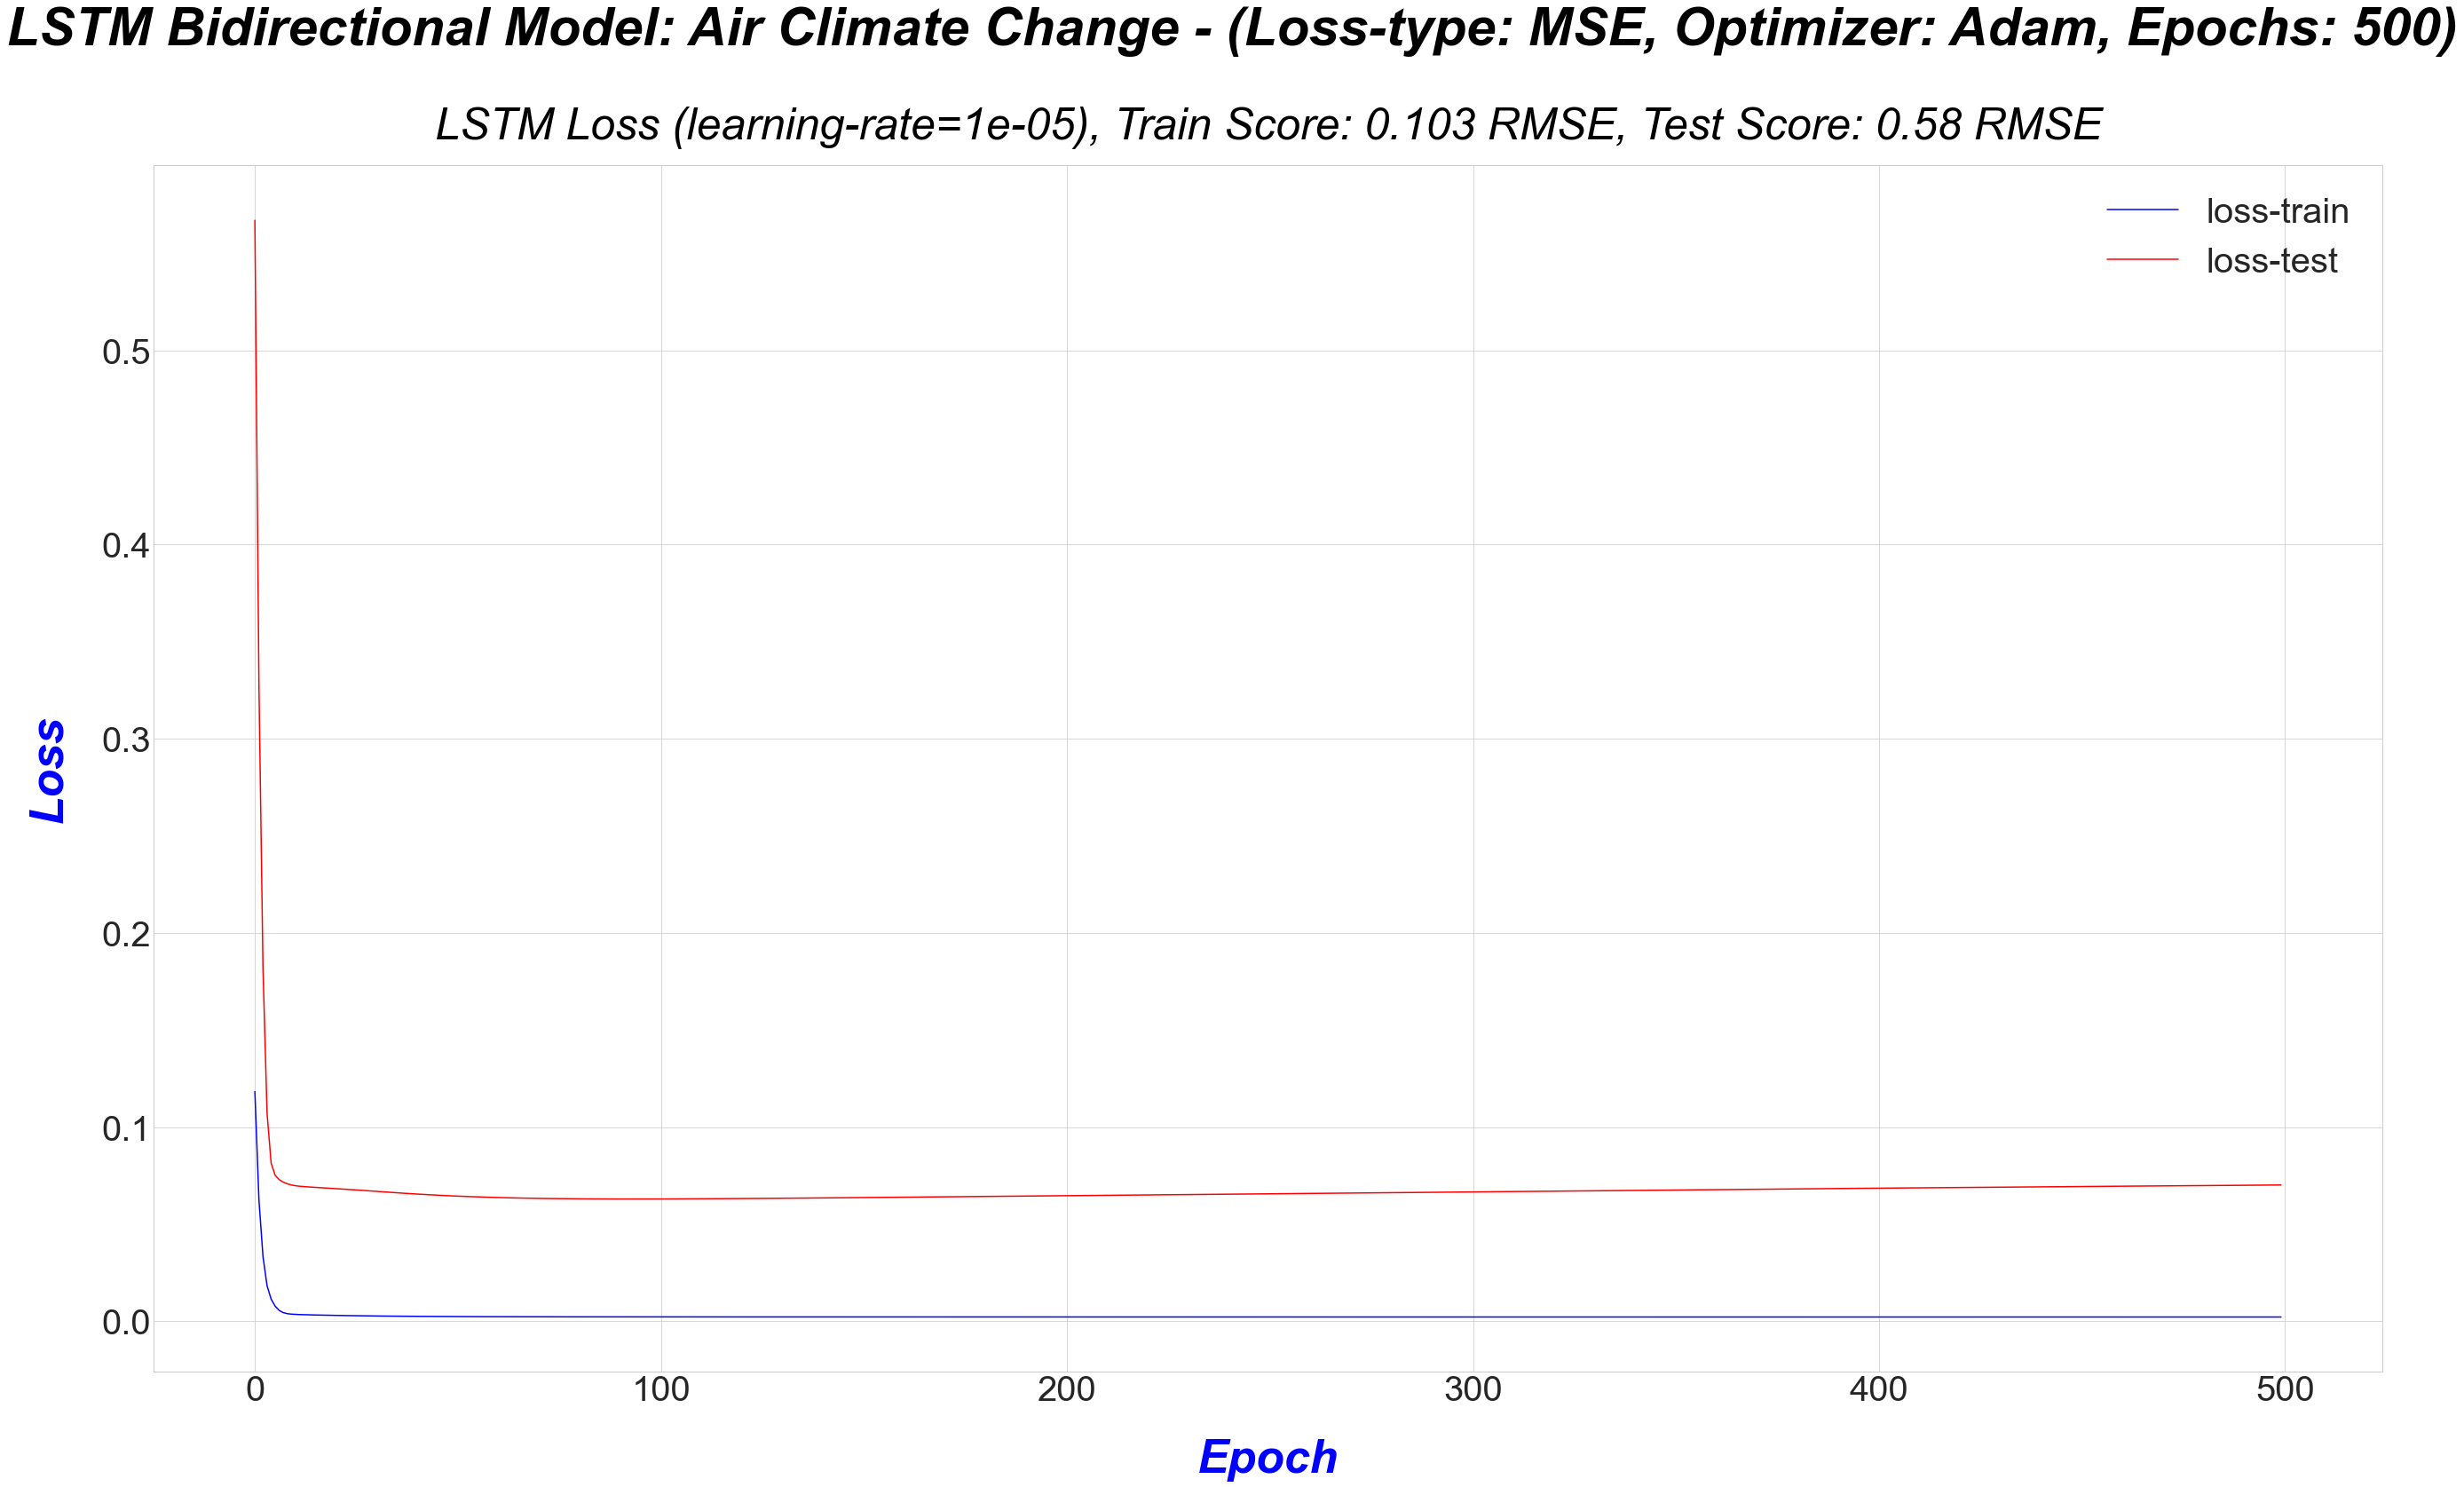

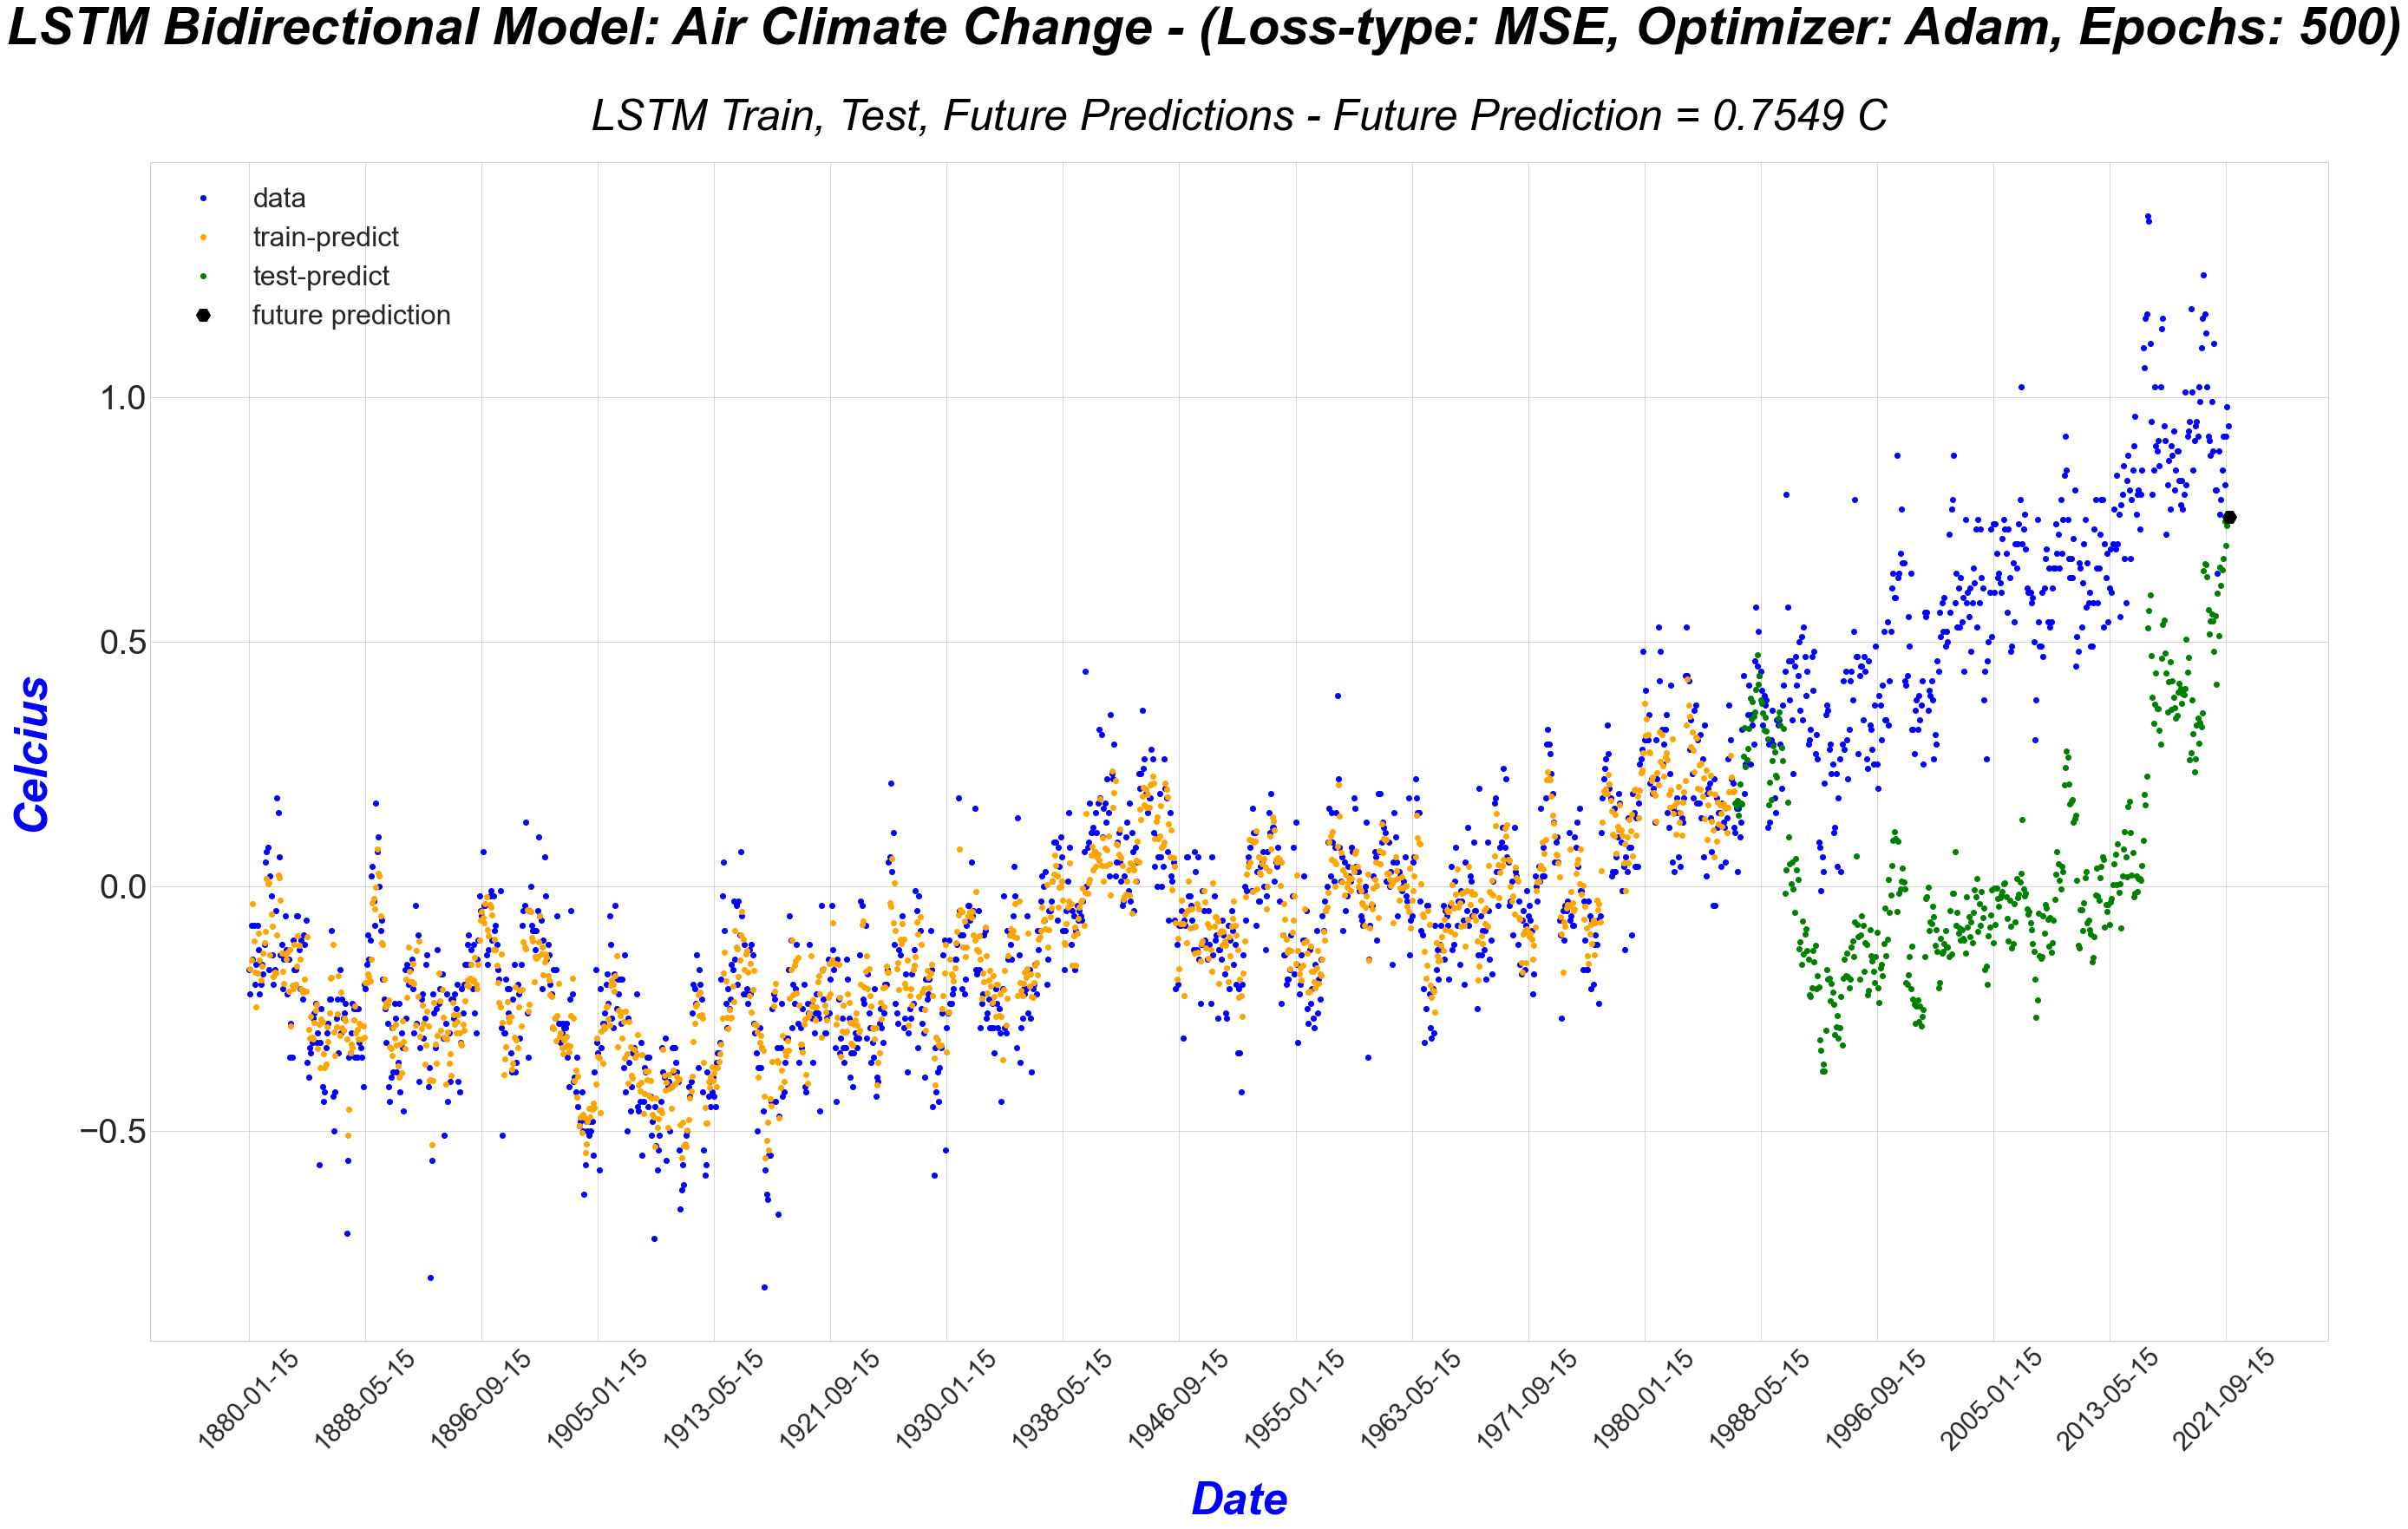

In [50]:
#
# Plot main dataset bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(out_col)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(out_col)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back):len(ds), :] = testPredict   

futurePredictPlot = np.empty_like(out_col)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history.history['loss'], "b", label='loss-train')
plt.plot(epochs, history.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/main-lstm-bidirectional-loss.png")
plt.show();


#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, col1, 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=16, label='future prediction')

plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/main-lstm-bidirectional-plot.png")
plt.show();